# Introduction <a class="anchor" id="intro" ></a>


In this notebook we are going to download an ECG dataset, and use different data analysis and machine learning tools to extract useful insights of the data.


### Table of contents
* [Introduction](#intro)
* [Let's code!](#lets_code)
   * [Load data](#load_data)
   * [Viewing ECG's](#viewing_ecg)
   * [R-Peak detection and heart rate measurement](#peak_detection)
   * [Processing dataset with deep learning](#deep_learning)
* [References](#references)



The approach for this coding challenge has several stages:
- Initial look at the data and the example provided
- Reference and paper search.
- Actual coding

# Let's code! <a class="anchor" id="lets_code" ></a> [(Go Up)](#intro)

First, load some python libraries to start working on the dataset

In [1]:
import wget
import os
import zipfile
import pandas as pd
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import ast
import seaborn as sns
sns.set()   # Sets the Seaborn style as default, even if we use 'plt' commands
sns.set_style("whitegrid")

## Load data <a class="anchor" id="load_data" ></a> [(Go Up)](#intro)


First, we are going to download and extract the data (might take a while)

In [2]:
root_folder_name = os.path.join(os.getcwd(), "data/")
folder_name = os.path.join(root_folder_name, 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/')
print("Local folder: " + folder_name)

if not os.path.exists(folder_name):
    
    if not os.path.exists(root_folder_name):
        os.makedirs(root_folder_name)

    file_url = "https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip"

    print("Downloading...")
    local_file_name = wget.download(file_url, root_folder_name)
    print("Extracting...")
    with zipfile.ZipFile(local_file_name, 'r') as z:
        z.extractall(root_folder_name)
    print("Done")
else:
    print("Local folder already found, didn't need to download")

Local folder: d:\Inventos\github\ai_for_health\data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/
Local folder already found, didn't need to download


Now we are going to load the dataset leveraging on the auxiliary functions provided in 'example_physionet.py'. 

In [3]:
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(folder_name+'ptbxl_database.csv', index_col='ecg_id', sep=',')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(folder_name+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


Also, I noted that **r_peaks** field is read by pandas as a string, so we need to parse it if we want to do something useful with it

In [4]:
# Parse R-Peaks data
def parse_rpeaks(x):
    x = x.replace('\n', '').strip('[ ]')
    x = x.replace('  ', ',').replace(' ', ',')
    x = ast.literal_eval(x)
    return x

Y['r_peaks'] = Y.r_peaks.apply(parse_rpeaks)

Let's take a look to the dataset

In [5]:
Y.head()

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       QRS-CLBB ST-ELEV-MI ST-DEPR-MI  Q-ISC  Q-ISC-QPeak  Q-ISC-V2V3  \
ecg_id                                                                  
1         False      False      False  False        False       False   
2         False      False      False  False        False       False   
3         False      False      False  False        False       False   
4         False      False      False  False        False       False   
5         False      False      False  False        False       False   

        Q-ISC-RPeak  STRAIN MI-ALL diagnostic_superclass  
ecg_id                                                    
1             False   False  False                [NORM]  
2             False   False  False                [NORM]  
3             False   False  False                [NORM]  
4             False   False  False                [NORM]  
5             False   False  False                [NORM]  

[5 rows x 44 columns]

It seems that Pandas is not displaying every field, so let's get a list of the available fields

In [6]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'r_peaks', 'RS-LVH', 'S12-LVH', 'R56-LVH', 'QRS-LVH', 'LI-LVH',
       'SLI-LVH', 'QRS-CLBB', 'ST-ELEV-MI', 'ST-DEPR-MI', 'Q-ISC',
       'Q-ISC-QPeak', 'Q-ISC-V2V3', 'Q-ISC-RPeak', 'STRAIN', 'MI-ALL',
       'diagnostic_superclass'],
      dtype='object')

Alright, that's a lot of data, so let's start with something easy, like:
- Number of samples
- Male/Female percentage
- Age distribution

Total number of samples in dataset = 21801
Male percentage = 52.09 %, Female percentage = 47.91 %


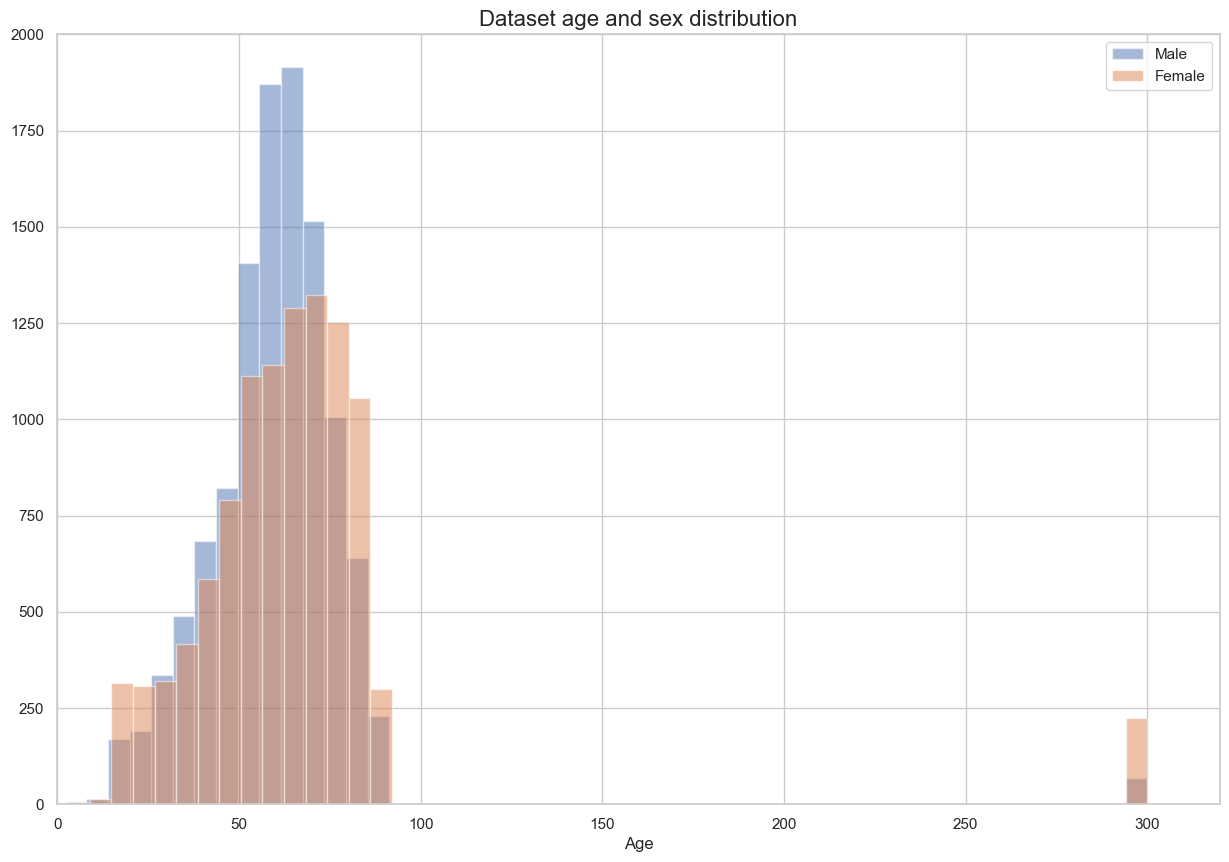

In [7]:
n_total_samples = len(Y)
n_male = len(Y.query("sex == 0"))
n_female = len(Y.query("sex == 1"))

print('Total number of samples in dataset = {0}'.format(n_total_samples))
print('Male percentage = {0:.2f} %, Female percentage = {1:.2f} %'.format(100*n_male/n_total_samples, 100*n_female/n_total_samples))

# Plot age distribution
plt.figure(figsize=(15, 10))
plt.hist(Y.query("sex == 0")['age'], bins=50, alpha=0.5, label='Male')
plt.hist(Y.query("sex == 1")['age'], bins=50, alpha=0.5, label='Female')
plt.legend()
plt.xlabel('Age')
plt.title('Dataset age and sex distribution', fontsize=16)
plt.xlim([0, 320])
plt.ylim([0, 2000])
plt.show()


Ok, so it seems that the dataset is well balanced regarding male/female distribution. Also age distribution is interesting, with some samples encoded in the range of 300 years. According to the description of the PTB-XL dataet these samples belong to people older than 89, in compliance with HIPAA standards.

Now, let's add a quick histogram of the possible diagnostics assigned to each ECG.

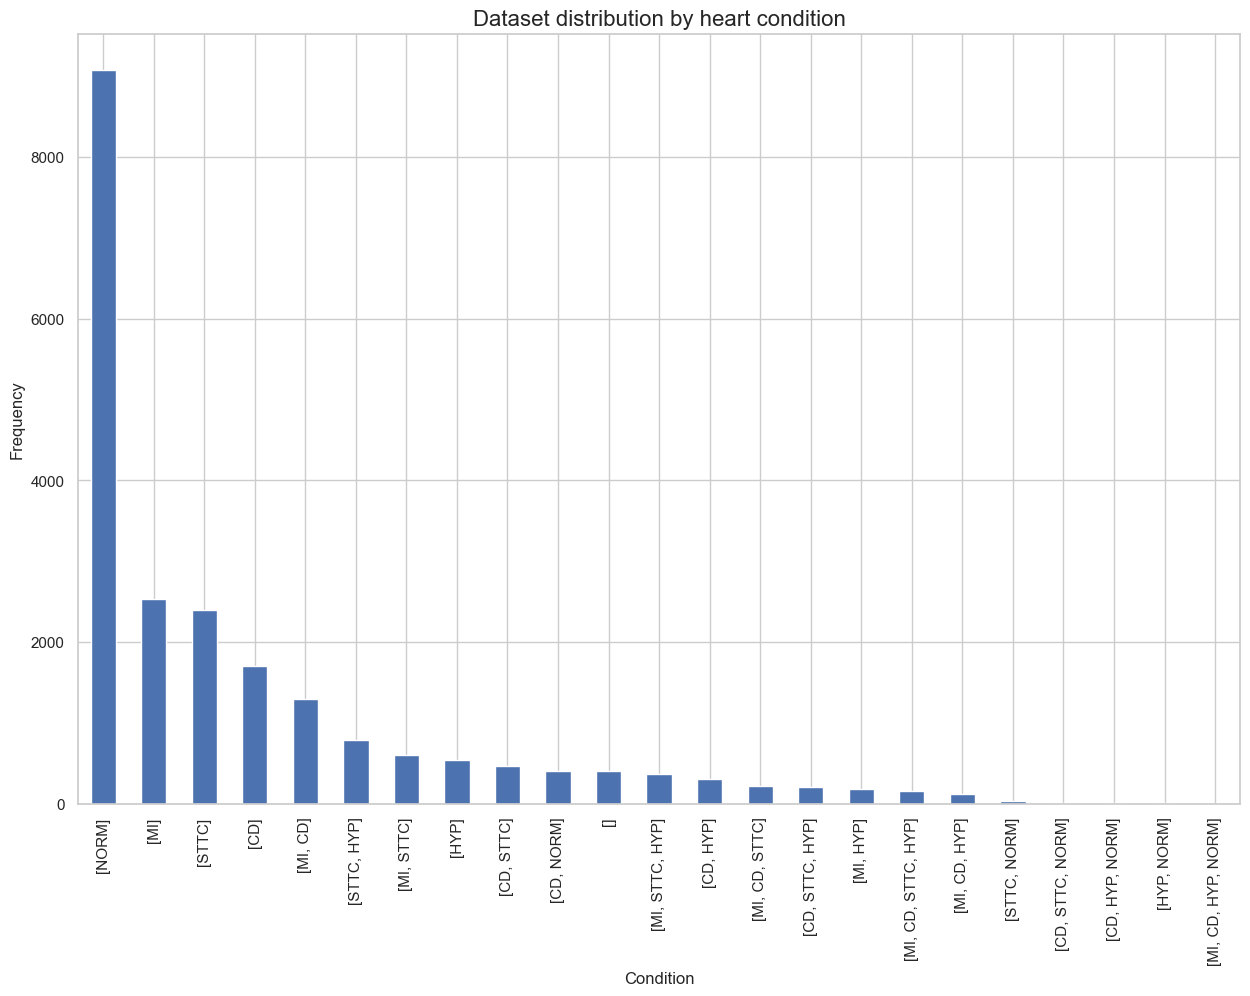

In [8]:
plt.figure(figsize=(15, 10))
Y.diagnostic_superclass.value_counts().plot.bar(figsize=(15,10))
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.title('Dataset distribution by heart condition', fontsize=16)
plt.show()

## Viewing ECG's <a class="anchor" id="viewing_ecg" ></a> [(Go Up)](#intro)

Now it's time to plot some actual ECG's. According to the description, for every ECG 12 leads are providen (I, II, III, AVR, AVL, AVF, V1-V6). We will use the signals downsampled to 100 Hz. Again, we will leverage on the function providen in the 'example_physionet.py' to load the data.

Also, we will plot the R-Peaks on the ECG, as marked by a physician.

In [9]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

For now we are doing just an exploratory analysis of the data, so there is no need of loading the complete dataset. Let's take a small sample.

In [10]:
# Load raw signal data
Y_sample = Y.sample(10)
X_sample = load_raw_data(Y_sample, sampling_rate, folder_name)

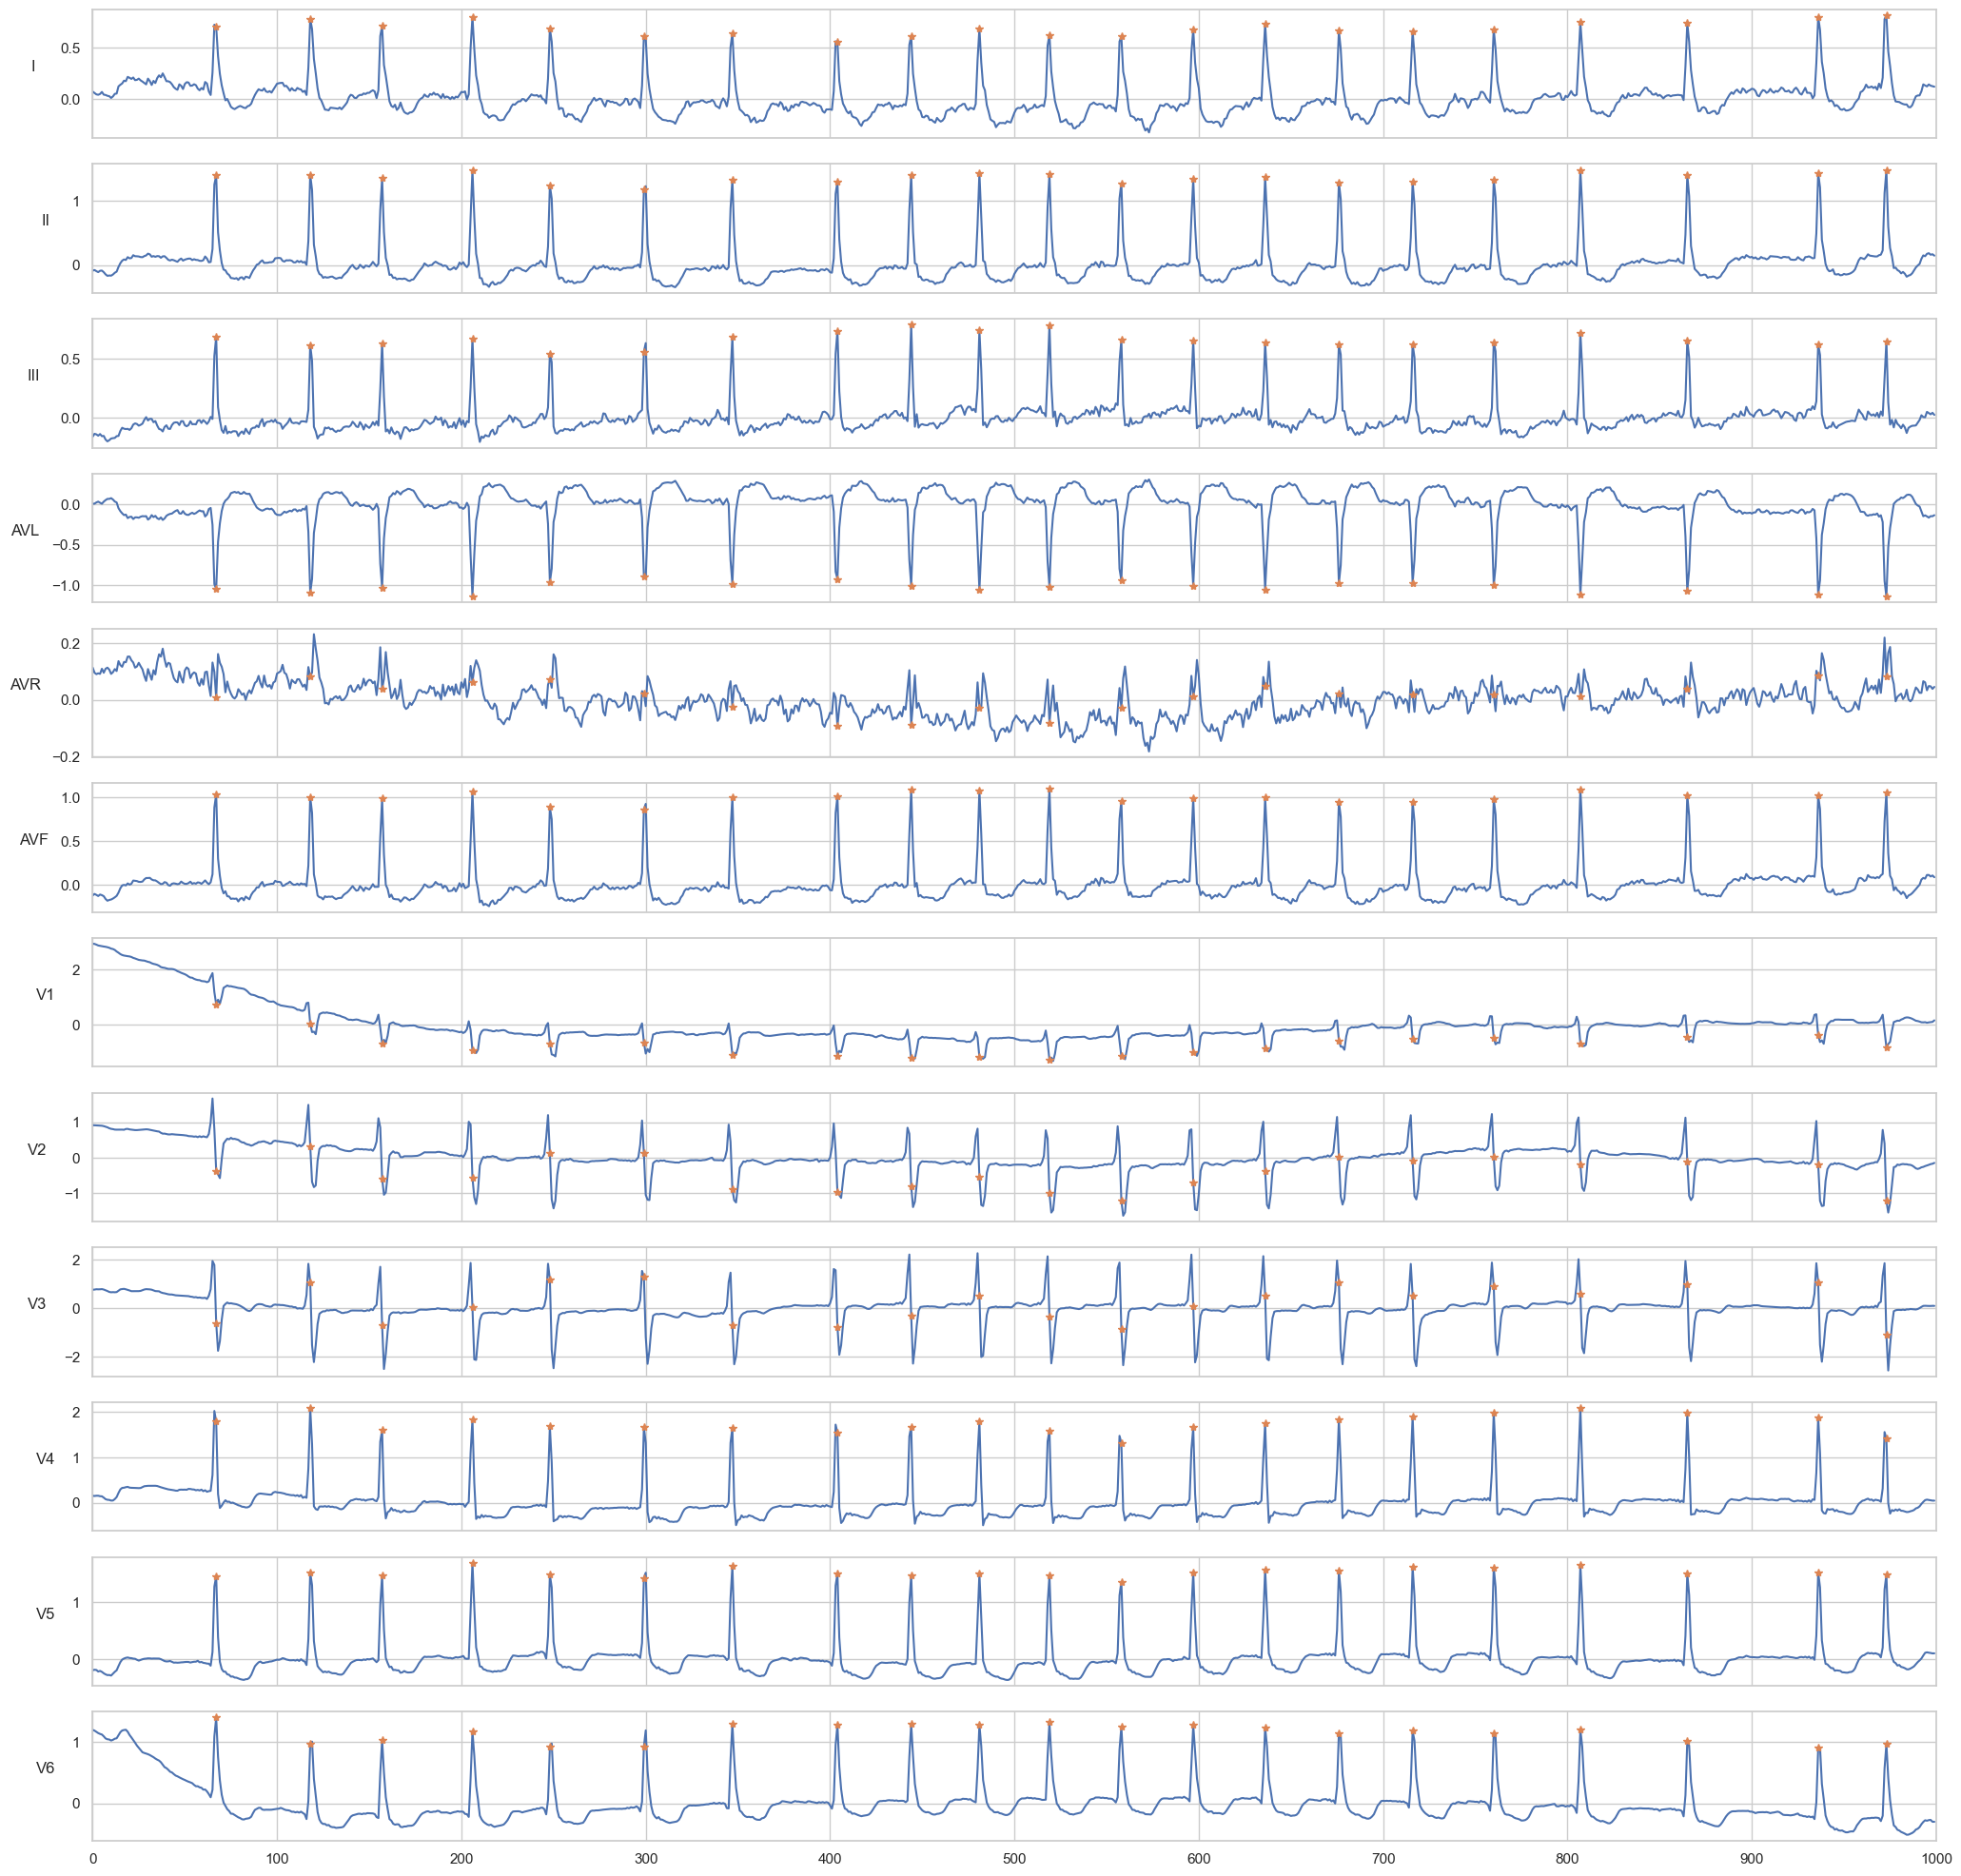

In [11]:

idx = 0     # index of ECG that we want to display
ecg = X_sample[idx]
peaks = Y_sample.r_peaks.iloc[idx]

leads = ['I', 'II', 'III', 'AVL', 'AVR', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Plot ECG
fig, axes = plt.subplots(nrows=12, ncols = 1, figsize=(25, 25), sharex=True)
for i in range(12):
    axes[i].plot(ecg[:,i])
    axes[i].plot(peaks, ecg[peaks, i], '*')
    axes[i].set_ylabel(leads[i], rotation=0, labelpad=20)
    
    axes[i].set_xlim([0, 1000])
    axes[i].set_xticks(np.arange(0, 1001, 100))
    
    #axes[i].set_ylim([-1.5, 1.5])
    #axes[i].set_yticks(np.arange(-1.5, 1.6, 0.5))

## R-Peak detection and heart rate measurement <a class="anchor" id="peak_detection"></a> [(Go Up)](#intro)

There are plenty of algorithms and studies on the automatic detection of the R-Peak, such as (3, 4, 5, 6), either using CNN, Wavelets and any other signal processing algorithms. Here we will explore a simple algorithm to detect R-Peaks in the I lead signal, as a proof of concept.

For the detection of the peaks we will use a template matching technique. Basically, the algorithm has 3 stages:
- Create a template of the R-Peak
- Cross-correlate the signal with this template. The processed signal will give have maximum points where the R-Peaks are.
- Group maxima and average groups, to filter the results.

In [12]:
def detect_peaks(ecg, threshold, sampling_rate):
    '''
    This function creates a template of the R-Peak using cos function and uses cross-correlation
    with the ECG signal. The correlated function will be maximum where the signal is simialr to
    the template (hopefully the peaks).

    Finally the correlated signal will be normalized and locations where it's higher than a set 
    threshold are returned
    '''
    # Create a wave to use as template (cosine function)
    # sampling rate must be taken into account to get a correctly sized template
    k_size = int(0.1*sampling_rate) 
    t = np.linspace(-1*np.pi, 1*np.pi, k_size)
    qrs_filter = np.cos(t)

    # Normalize ECG signal
    ecg = (ecg - ecg.mean()) / ecg.std()

    # Calculate correlation between ECG and template
    corr = np.correlate(ecg, qrs_filter, mode='same')
    corr = corr / np.max(corr)

    return np.where(corr > threshold)[0]

def group_peaks(peaks, threshold = 35):
    '''
    This function will group together those points that are close, and will belong to a same
    peak. Then, every group is averaged and the return value is a filtered array of maxima
    '''
    # Calculate relative distance between peaks
    diff = np.diff(peaks)

    # Group using relative distance between peaks
    groups = []
    group = []
    for i in range(len(diff)):
        if diff[i] < threshold:
            group.append(peaks[i])
        else:
            group.append(peaks[i])
            groups.append(group)
            group = []
    groups.append(group)

    # Calculate averga of every group
    filtered_peaks = []
    for g in groups:
        if len(g) > 0:
            p = int(np.round(np.mean(g)))
            filtered_peaks.append(p)

    return np.array(filtered_peaks)


def detect_r_peak(ecg, threshold=0.5, sampling_rate=100):
    '''
    This function returns the location of the R-Peaks detected in an ECG singal
    '''
    peaks = detect_peaks(ecg, threshold, sampling_rate)
    filt_peaks = group_peaks(peaks, 5)
    
    return filt_peaks

def get_bpm(peaks, sampling_rate=100):
    '''
    This function calculates the averaged BPM Heart Rate using an array of R-Peaks
    '''
    rate = sampling_rate / np.mean(np.diff(peaks)) * 60
    return rate


Alright, let's test the algorithm with our example ECG signal.

Estimated peaks: [ 68 119 158 207 249 300 348 404 444 482 520 559 598 637 677 717 761 808
 866 937 974]
HR = 132.5 bpm


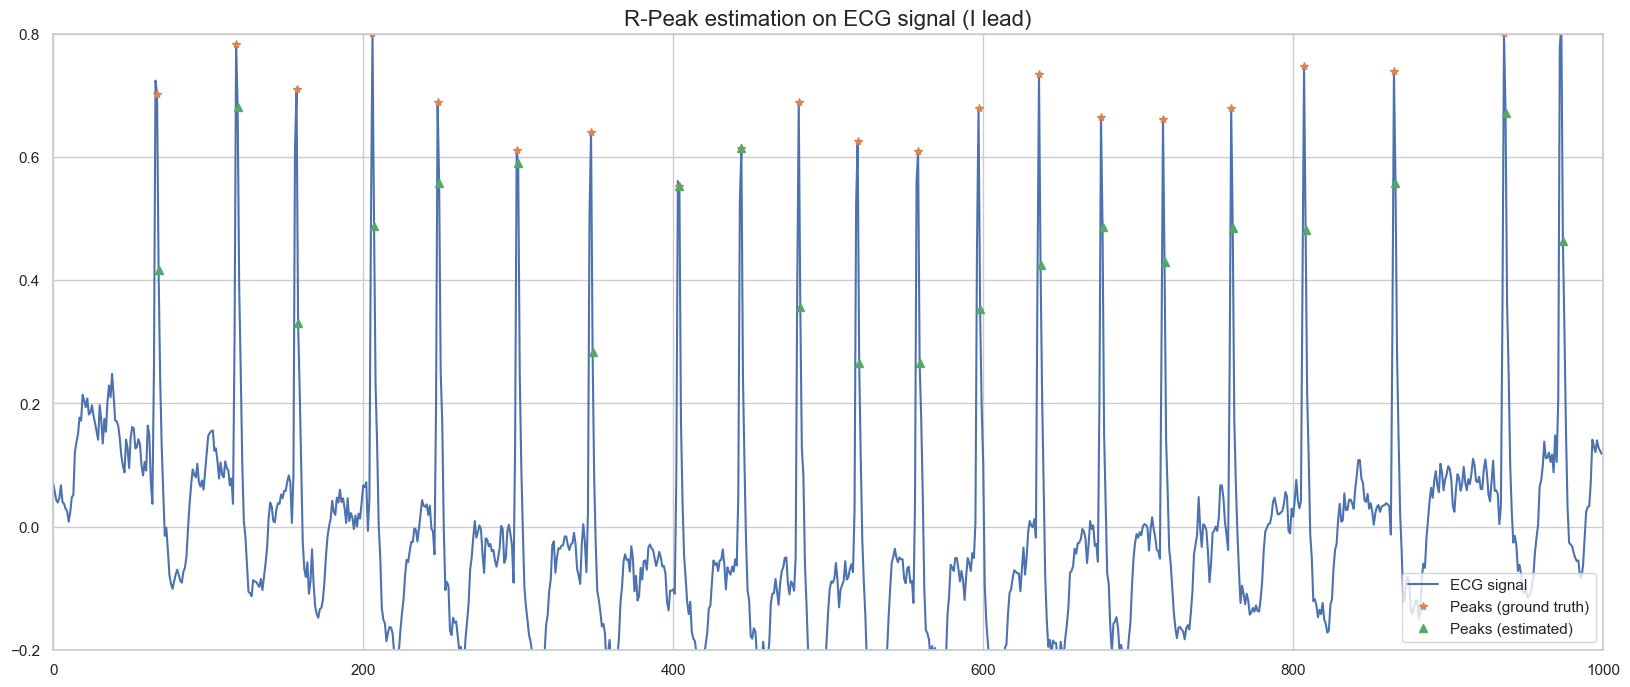

In [13]:
# Estimate R-Peaks
estimated_peaks = detect_r_peak(ecg[:,0]) # using I lead
heart_rate = get_bpm(estimated_peaks)

# Print heart rate
print('Estimated peaks: {0}'.format(estimated_peaks))
print('HR = {0:.1f} bpm'.format(heart_rate))

# Plot results
plt.figure(figsize=(20,8))
plt.plot(ecg[:,0], label='ECG signal')
plt.plot(peaks, ecg[peaks, 0], '*', label='Peaks (ground truth)')
plt.plot(estimated_peaks, ecg[estimated_peaks, 0], '^', label='Peaks (estimated)')
plt.xlim([0, 1000])
plt.ylim([-0.2, 0.8])
plt.legend(loc='lower right')
plt.title('R-Peak estimation on ECG signal (I lead)', fontsize=16)
plt.show()


Ok, it seems that this simple algorithm is behaving nicely on this example. Now let's test it for a bigger sample. It would be nice to have an estimator of how good are the detections compared to the annotated data. We will get for every predicted peak the closest ground truth value. Then will get the Root Mean Squared error of those differences.

In [14]:
def estimate_detection_rms(truth, predicted, threshold=40):
    '''
    If the closest GT to a predicted peak is further
    than this threshold, we will assume that they are
    refering to different peaks and therefore will
    not be considered in the error estimation
    '''
    diff_list = []
    for pr in predicted:
        closest = min(truth, key=lambda x:abs(x - pr))
        diff = pr - closest
        if diff < threshold:
            diff_list.append(diff)

    diffs = np.array(diff_list)
    error = np.sqrt(np.mean(diffs**2))
    return error

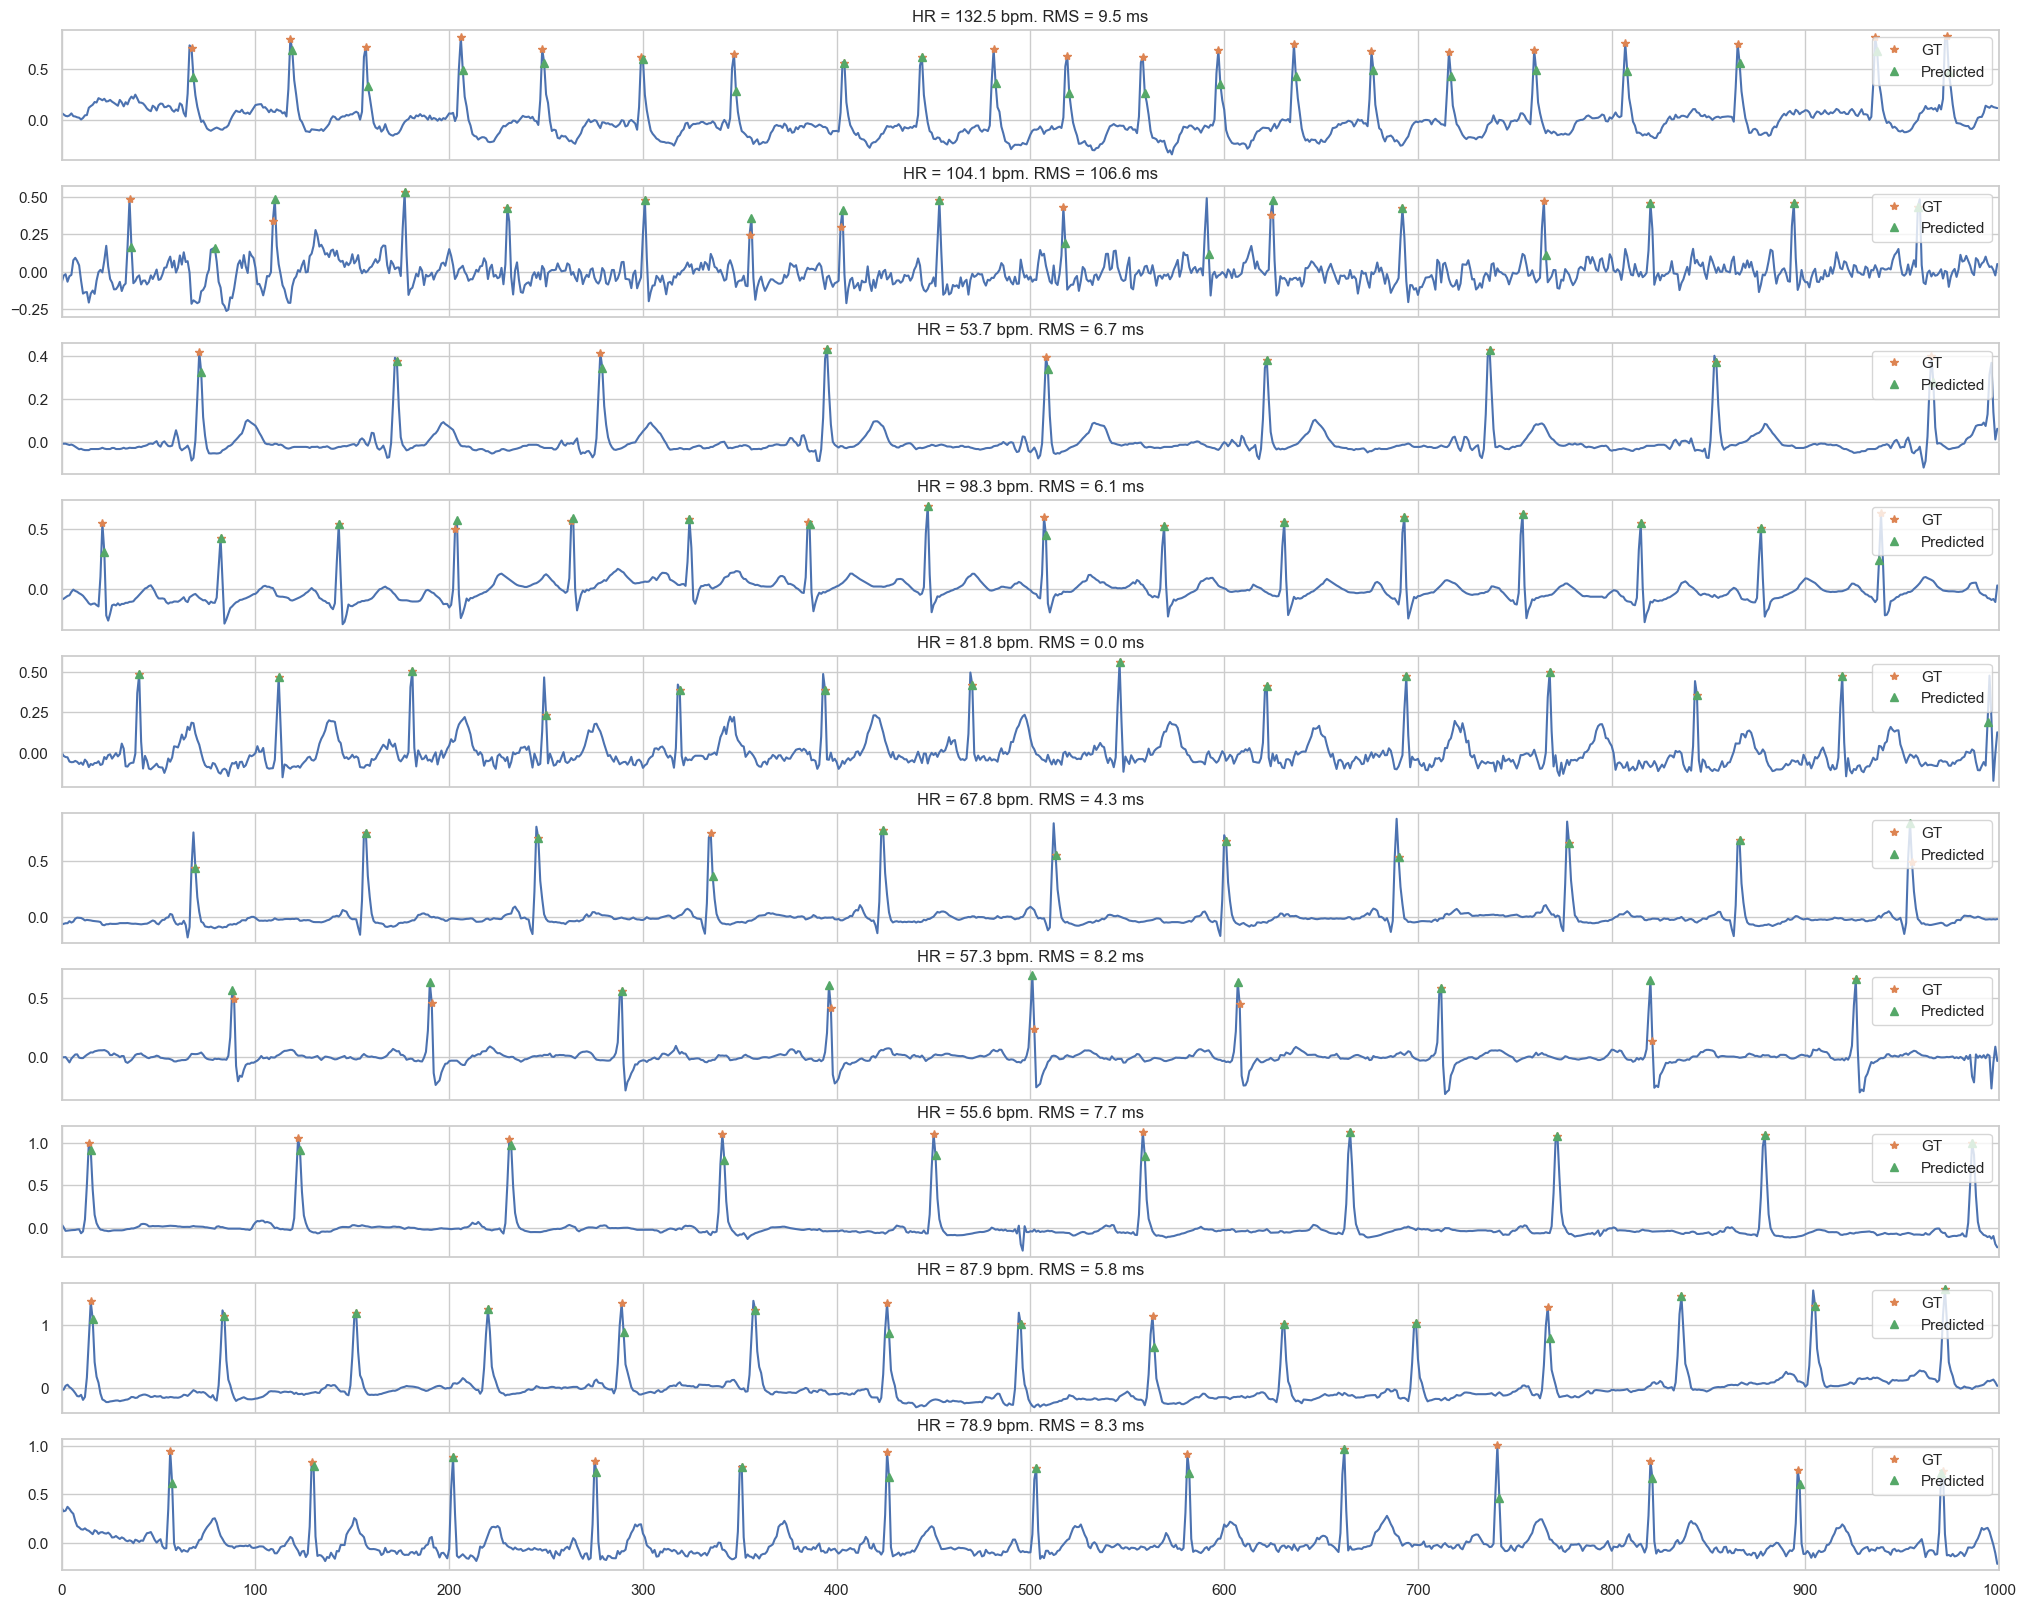

In [15]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(25, 20), sharex=True)

for i in range(10):
    # Get sample and estimate peaks
    ecg = X_sample[i]
    peaks = Y_sample.r_peaks.iloc[i]
    est_peaks = detect_r_peak(ecg[:,0])
    hr = get_bpm(est_peaks)
    rms = estimate_detection_rms(peaks, est_peaks) / sampling_rate * 1000 # get the averaged error in milliseconds
    
    # Plot results
    axes[i].plot(ecg[:,0])
    axes[i].plot(peaks, ecg[peaks, 0], '*', label='GT')
    axes[i].plot(est_peaks, ecg[est_peaks, 0], '^', label='Predicted')
    axes[i].set_xlim([0, 1000])
    axes[i].set_xticks(np.arange(0, 1001, 100))
    axes[i].legend(loc='upper right')
    axes[i].set_title('HR = {0:.1f} bpm. RMS = {1:.1f} ms'.format(hr, rms))


The designed algorithm works pretty nicely given its simplicity, although in a bigger sample it will for sure present some false detections. There are plenty of measures to improve the results and make a more robust detection:
- Use adaptive thresholds, instead of a fixed value
- Compare peak-to-peak distances in order to filter out false detections
- Create specific templates and run peak detection for every lead. After that average and filter outliers


## Peak detector using deep learning <a class="anchor" id="peak_dl" ></a> [(Go Up)](#intro)

Another approach for peak detection, which could achieve good results without putting a lot of effort, is to train a small CNN to process ECG data. First, let's load some Deep Learning packages

In [16]:
# Import deep learning libraries
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses

# Fix random seeds for result reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Now let's start by loading the complete dataset and splitting it into train and test batches, as stated in the description of the dataset

In [17]:
# Load raw signal data
X = load_raw_data(Y, sampling_rate, folder_name)

# Split data into train and test
test_fold = 10
# Train
X_train_ = X[np.where(Y.strat_fold != test_fold)]
peaks_train = Y[(Y.strat_fold != test_fold)].r_peaks
# Test
X_test_ = X[np.where(Y.strat_fold == test_fold)]
peaks_test = Y[Y.strat_fold == test_fold].r_peaks

We will use this quick function to create 'label' data using the peak positions

In [18]:
def generate_labels(peak_list, size=1000):
    y_list = []
    for p in peak_list:
        y = np.zeros(size)
        y[np.array(p)] = 1.0
        y_list.append(y)
    return y_list

Now let's create the actual Train/Test dataset

In [19]:
X_train = np.expand_dims(X_train_, axis=-1)
X_test = np.expand_dims(X_test_, axis=-1)

y_train = np.expand_dims(np.array(generate_labels(peaks_train)), axis=-1)
y_test = np.expand_dims(np.array(generate_labels(peaks_test)), axis=-1)

It's time to define our peak detection model. It's based on a simple fully convolutional network.

In [20]:
peak_detector = models.Sequential()
peak_detector.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1000, 12, 1)))
peak_detector.add(layers.AveragePooling2D(pool_size=(1,2)))
peak_detector.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
peak_detector.add(layers.AveragePooling2D(pool_size=(1,2)))
peak_detector.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",))
peak_detector.add(layers.AveragePooling2D(pool_size=(1,2)))
peak_detector.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding="same",))
peak_detector.add(layers.Reshape((1000, 1)))

peak_detector.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 12, 32)      320       
                                                                 
 average_pooling2d (AverageP  (None, 1000, 6, 32)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 1000, 6, 64)       18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 1000, 3, 64)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1000, 3, 32)       18464     
                                                                 
 average_pooling2d_2 (Averag  (None, 1000, 1, 32)      0

Training time!

In [21]:
peak_detector.compile(optimizer='adam',
              loss=losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = peak_detector.fit(X_train, y_train, epochs=10,
                            validation_data=(X_test, y_test))

Epoch 1/10
613/613 [==============================] - 100s 163ms/step - loss: 0.0442 - accuracy: 0.9918 - val_loss: 0.0113 - val_accuracy: 0.9956
Epoch 2/10
613/613 [==============================] - 91s 148ms/step - loss: 0.0105 - accuracy: 0.9959 - val_loss: 0.0097 - val_accuracy: 0.9961
Epoch 3/10
613/613 [==============================] - 91s 149ms/step - loss: 0.0097 - accuracy: 0.9961 - val_loss: 0.0094 - val_accuracy: 0.9962
Epoch 4/10
613/613 [==============================] - 91s 148ms/step - loss: 0.0092 - accuracy: 0.9963 - val_loss: 0.0089 - val_accuracy: 0.9963
Epoch 5/10
613/613 [==============================] - 91s 148ms/step - loss: 0.0089 - accuracy: 0.9964 - val_loss: 0.0088 - val_accuracy: 0.9964
Epoch 6/10
613/613 [==============================] - 93s 151ms/step - loss: 0.0086 - accuracy: 0.9965 - val_loss: 0.0085 - val_accuracy: 0.9965
Epoch 7/10
613/613 [==============================] - 92s 150ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.0084 - val_a

Finally, let's see how well our model performs

1/1 [==============================] - 0s 66ms/step


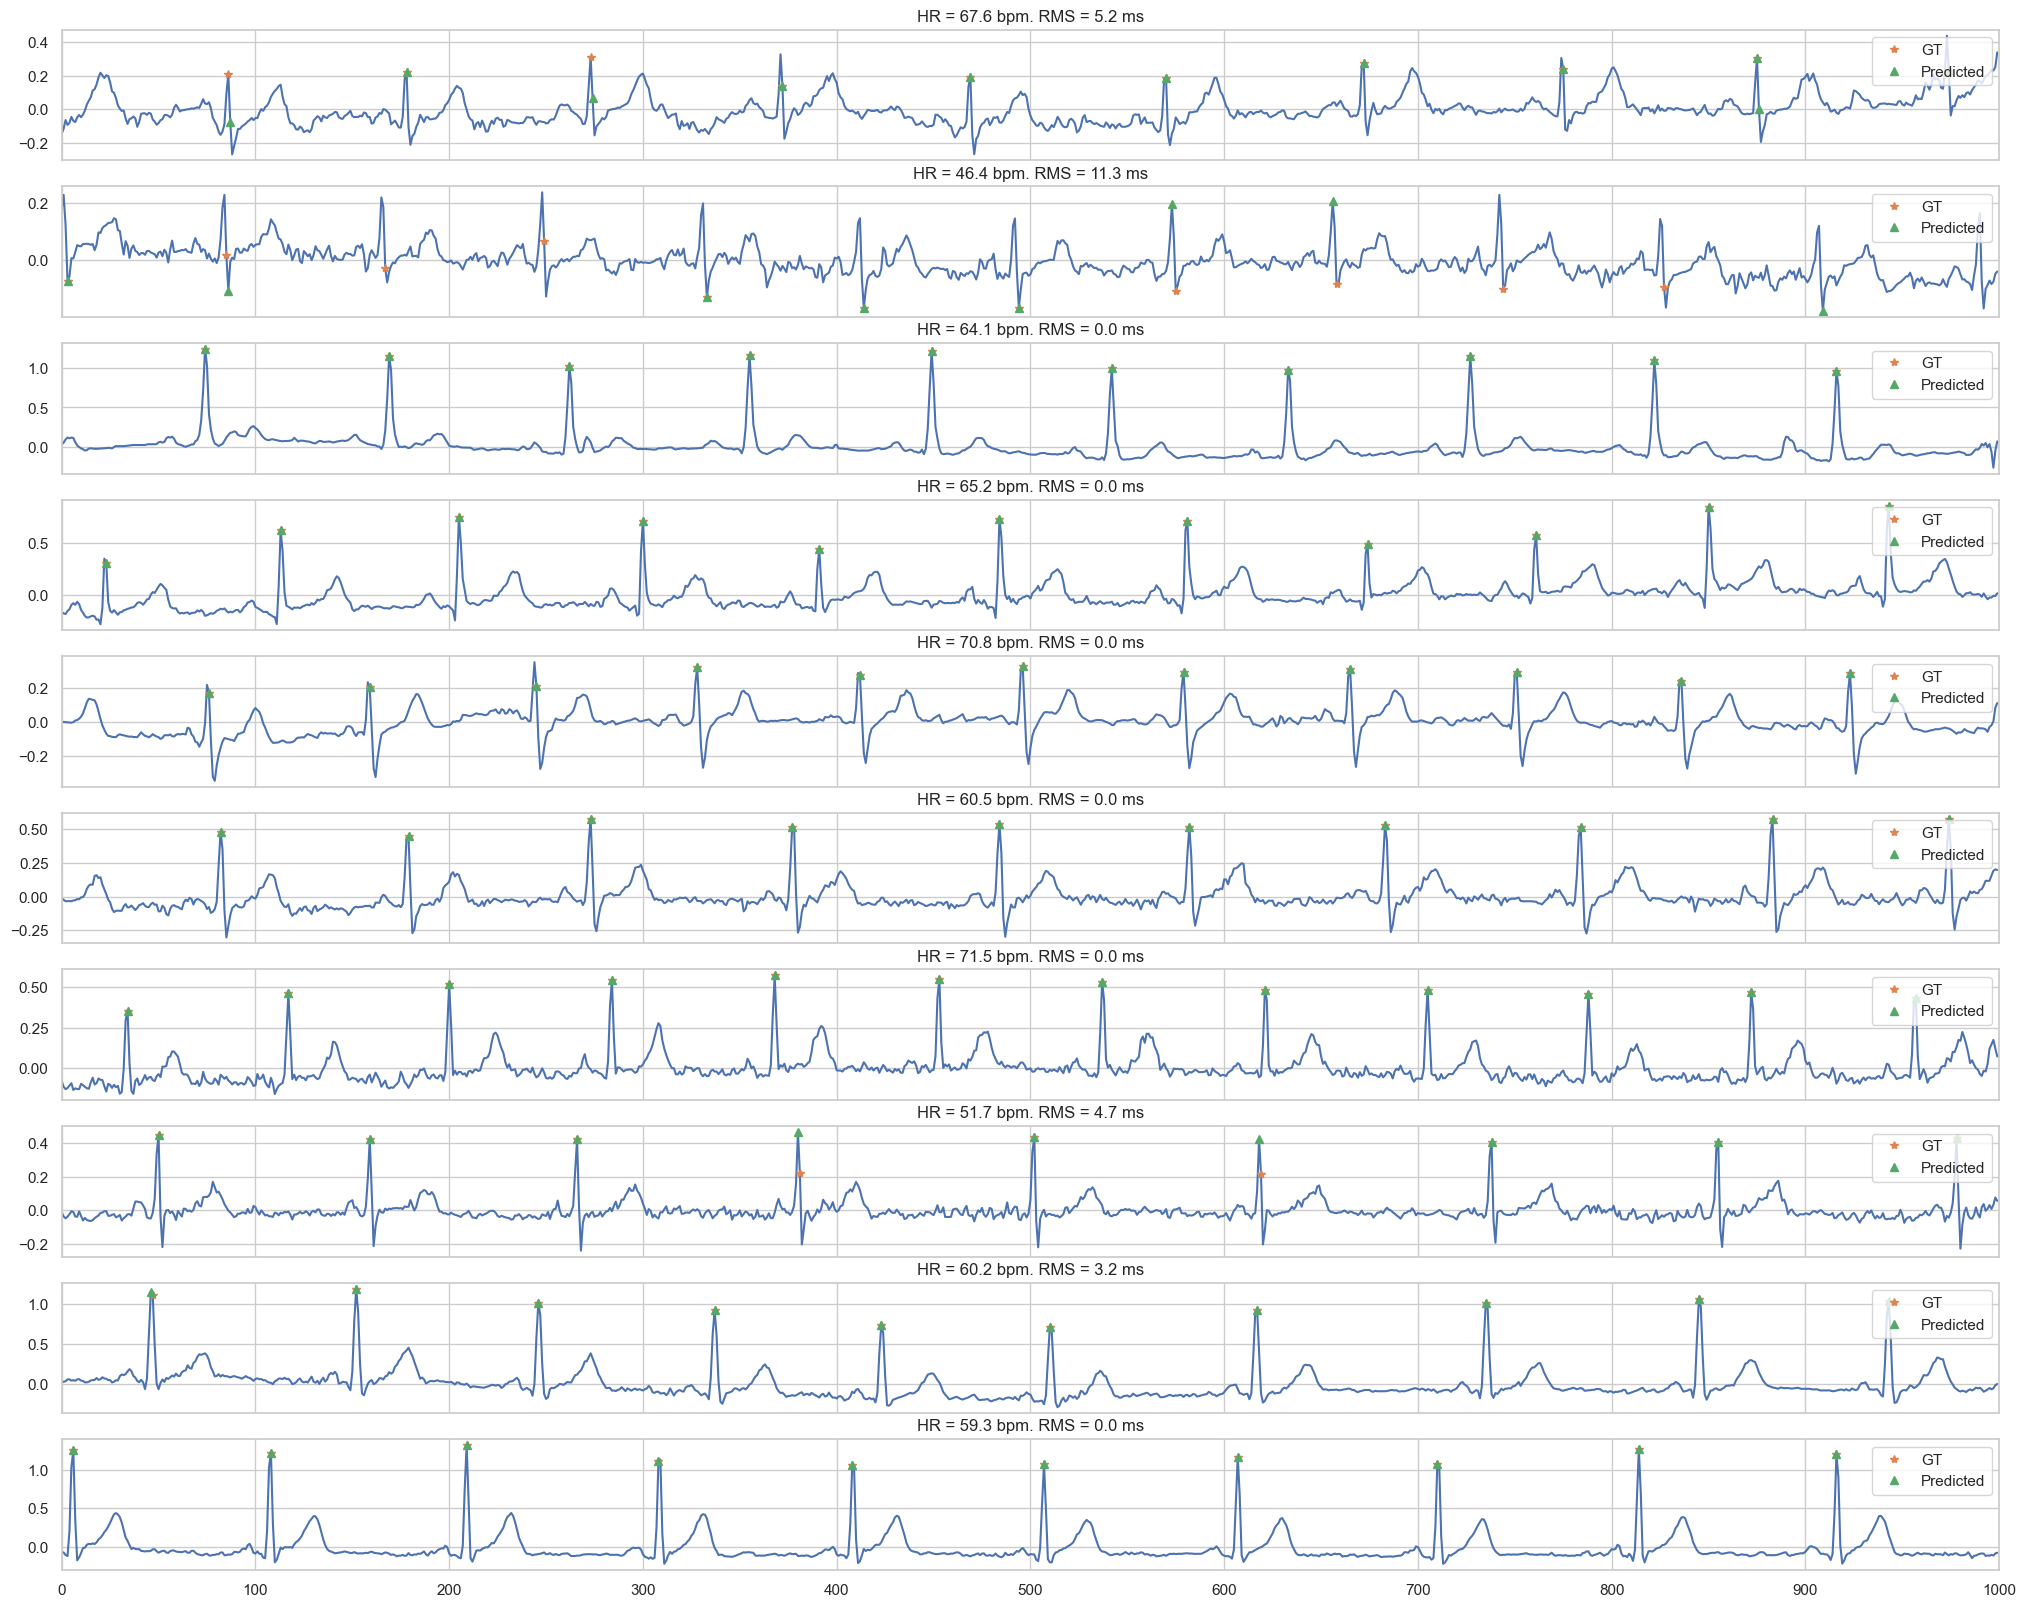

In [22]:
y_pred = peak_detector.predict(X_test[0:10])[:,:,0]

fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(25, 20), sharex=True)

for i in range(10):
    ecg = X_test[i, :, :, 0]
    peaks = peaks_test.iloc[i]
    prediction = np.where(y_pred[i] > 0.5)[0]
    hr = get_bpm(prediction)
    rms = estimate_detection_rms(peaks, prediction) / sampling_rate * 1000 

    # Plot results
    axes[i].plot(ecg[:,0])
    axes[i].plot(peaks, ecg[peaks, 0], '*', label='GT')
    axes[i].plot(prediction, ecg[prediction, 0], '^', label='Predicted')
    axes[i].set_xlim([0, 1000])
    axes[i].set_xticks(np.arange(0, 1001, 100))
    axes[i].legend(loc='upper right')
    axes[i].set_title('HR = {0:.1f} bpm. RMS = {1:.1f} ms'.format(hr, rms))

So it seems that the deep learning model is returning pretty accurate peak detections, without needing any prior knowledge of the signal itself. Using a neural network for a simple peak detection might seem a bit overkill, but on the other hand, given how nowadays deep learning algorithms are higly optimized to run in GPUs, it may be even more efficient than any other hand-made algorithm, so it is an approach that shouldn't be neglected

# Processing dataset with deep learning <a class="anchor" id="deep_learning" ></a> [(Go Up)](#intro)

There are numerouse studies on using different deep learning classifiers for ECG signals. In fact, in (2) the same authors that released the Dataset evaluate the perfomance of different popular deep learning models for this task.

Instead, I would like to analyze differences between correct signals and others with the presence of several sources of noise. Although it is also a well studied topic (7, 8), from the preliminar research done for this challenge, it seems that using deep learning to filter ECG signals is an interesting topic to work on.

So, let's start splitting the dataset according to the presence of different sources of noise.

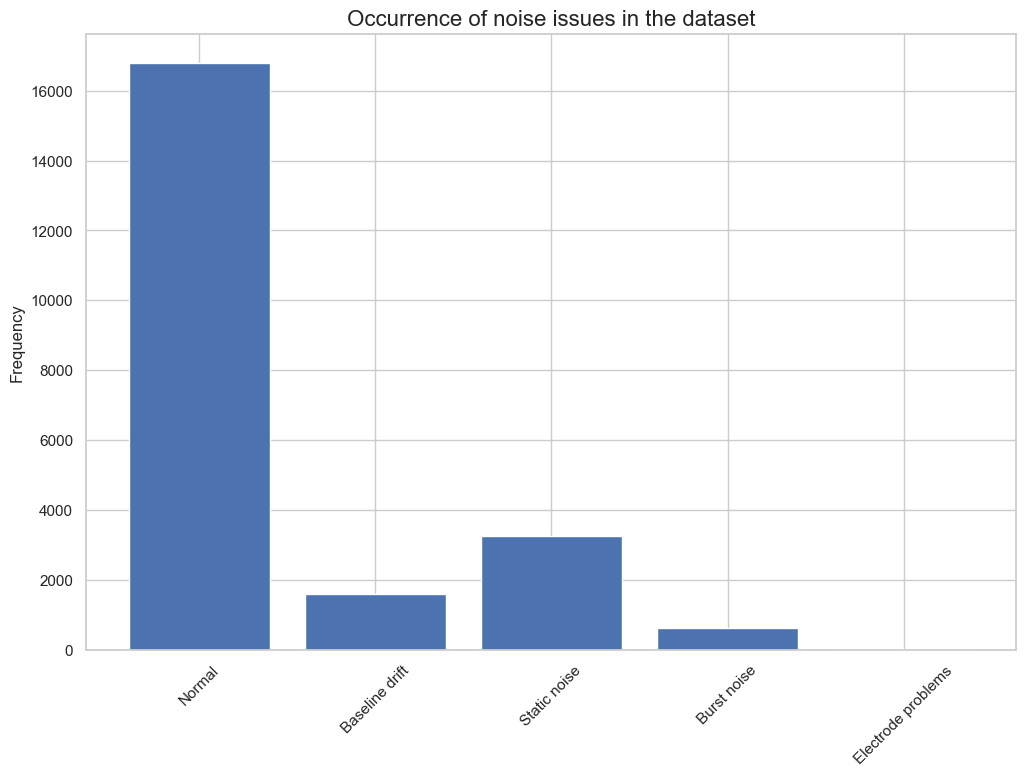

In [23]:
labels = ['Normal', 'Baseline drift', 'Static noise', 'Burst noise', 'Electrode problems']

occurrence = [
    len(Y[Y.baseline_drift.isna() & 
              Y.static_noise.isna() & 
              Y.burst_noise.isna() & 
              Y.electrodes_problems.isna()]),
    Y.baseline_drift.count(),
    Y.static_noise.count(),
    Y.burst_noise.count(),
    Y.electrodes_problems.count(),
]

plt.figure(figsize=(12,8))
plt.bar(labels, occurrence)
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Occurrence of noise issues in the dataset', fontsize=16)
plt.show()

Ok, now let's sample some ECG's and check how they look

In [24]:
Y_normal = Y[Y.baseline_drift.isna() & 
              Y.static_noise.isna() & 
              Y.burst_noise.isna() & 
              Y.electrodes_problems.isna()].sample(10)
Y_baseline = Y[Y.baseline_drift.notna()].sample(10)
Y_static = Y[Y.static_noise.notna()].sample(10)
Y_burst = Y[Y.burst_noise.notna()].sample(10)
Y_electrodes = Y[Y.electrodes_problems.notna()].sample(10)

X_normal = load_raw_data(Y_normal, sampling_rate, folder_name)
X_baseline = load_raw_data(Y_baseline, sampling_rate, folder_name)
X_static = load_raw_data(Y_static, sampling_rate, folder_name)
X_burst = load_raw_data(Y_burst, sampling_rate, folder_name)
X_electrodes = load_raw_data(Y_electrodes, sampling_rate, folder_name)

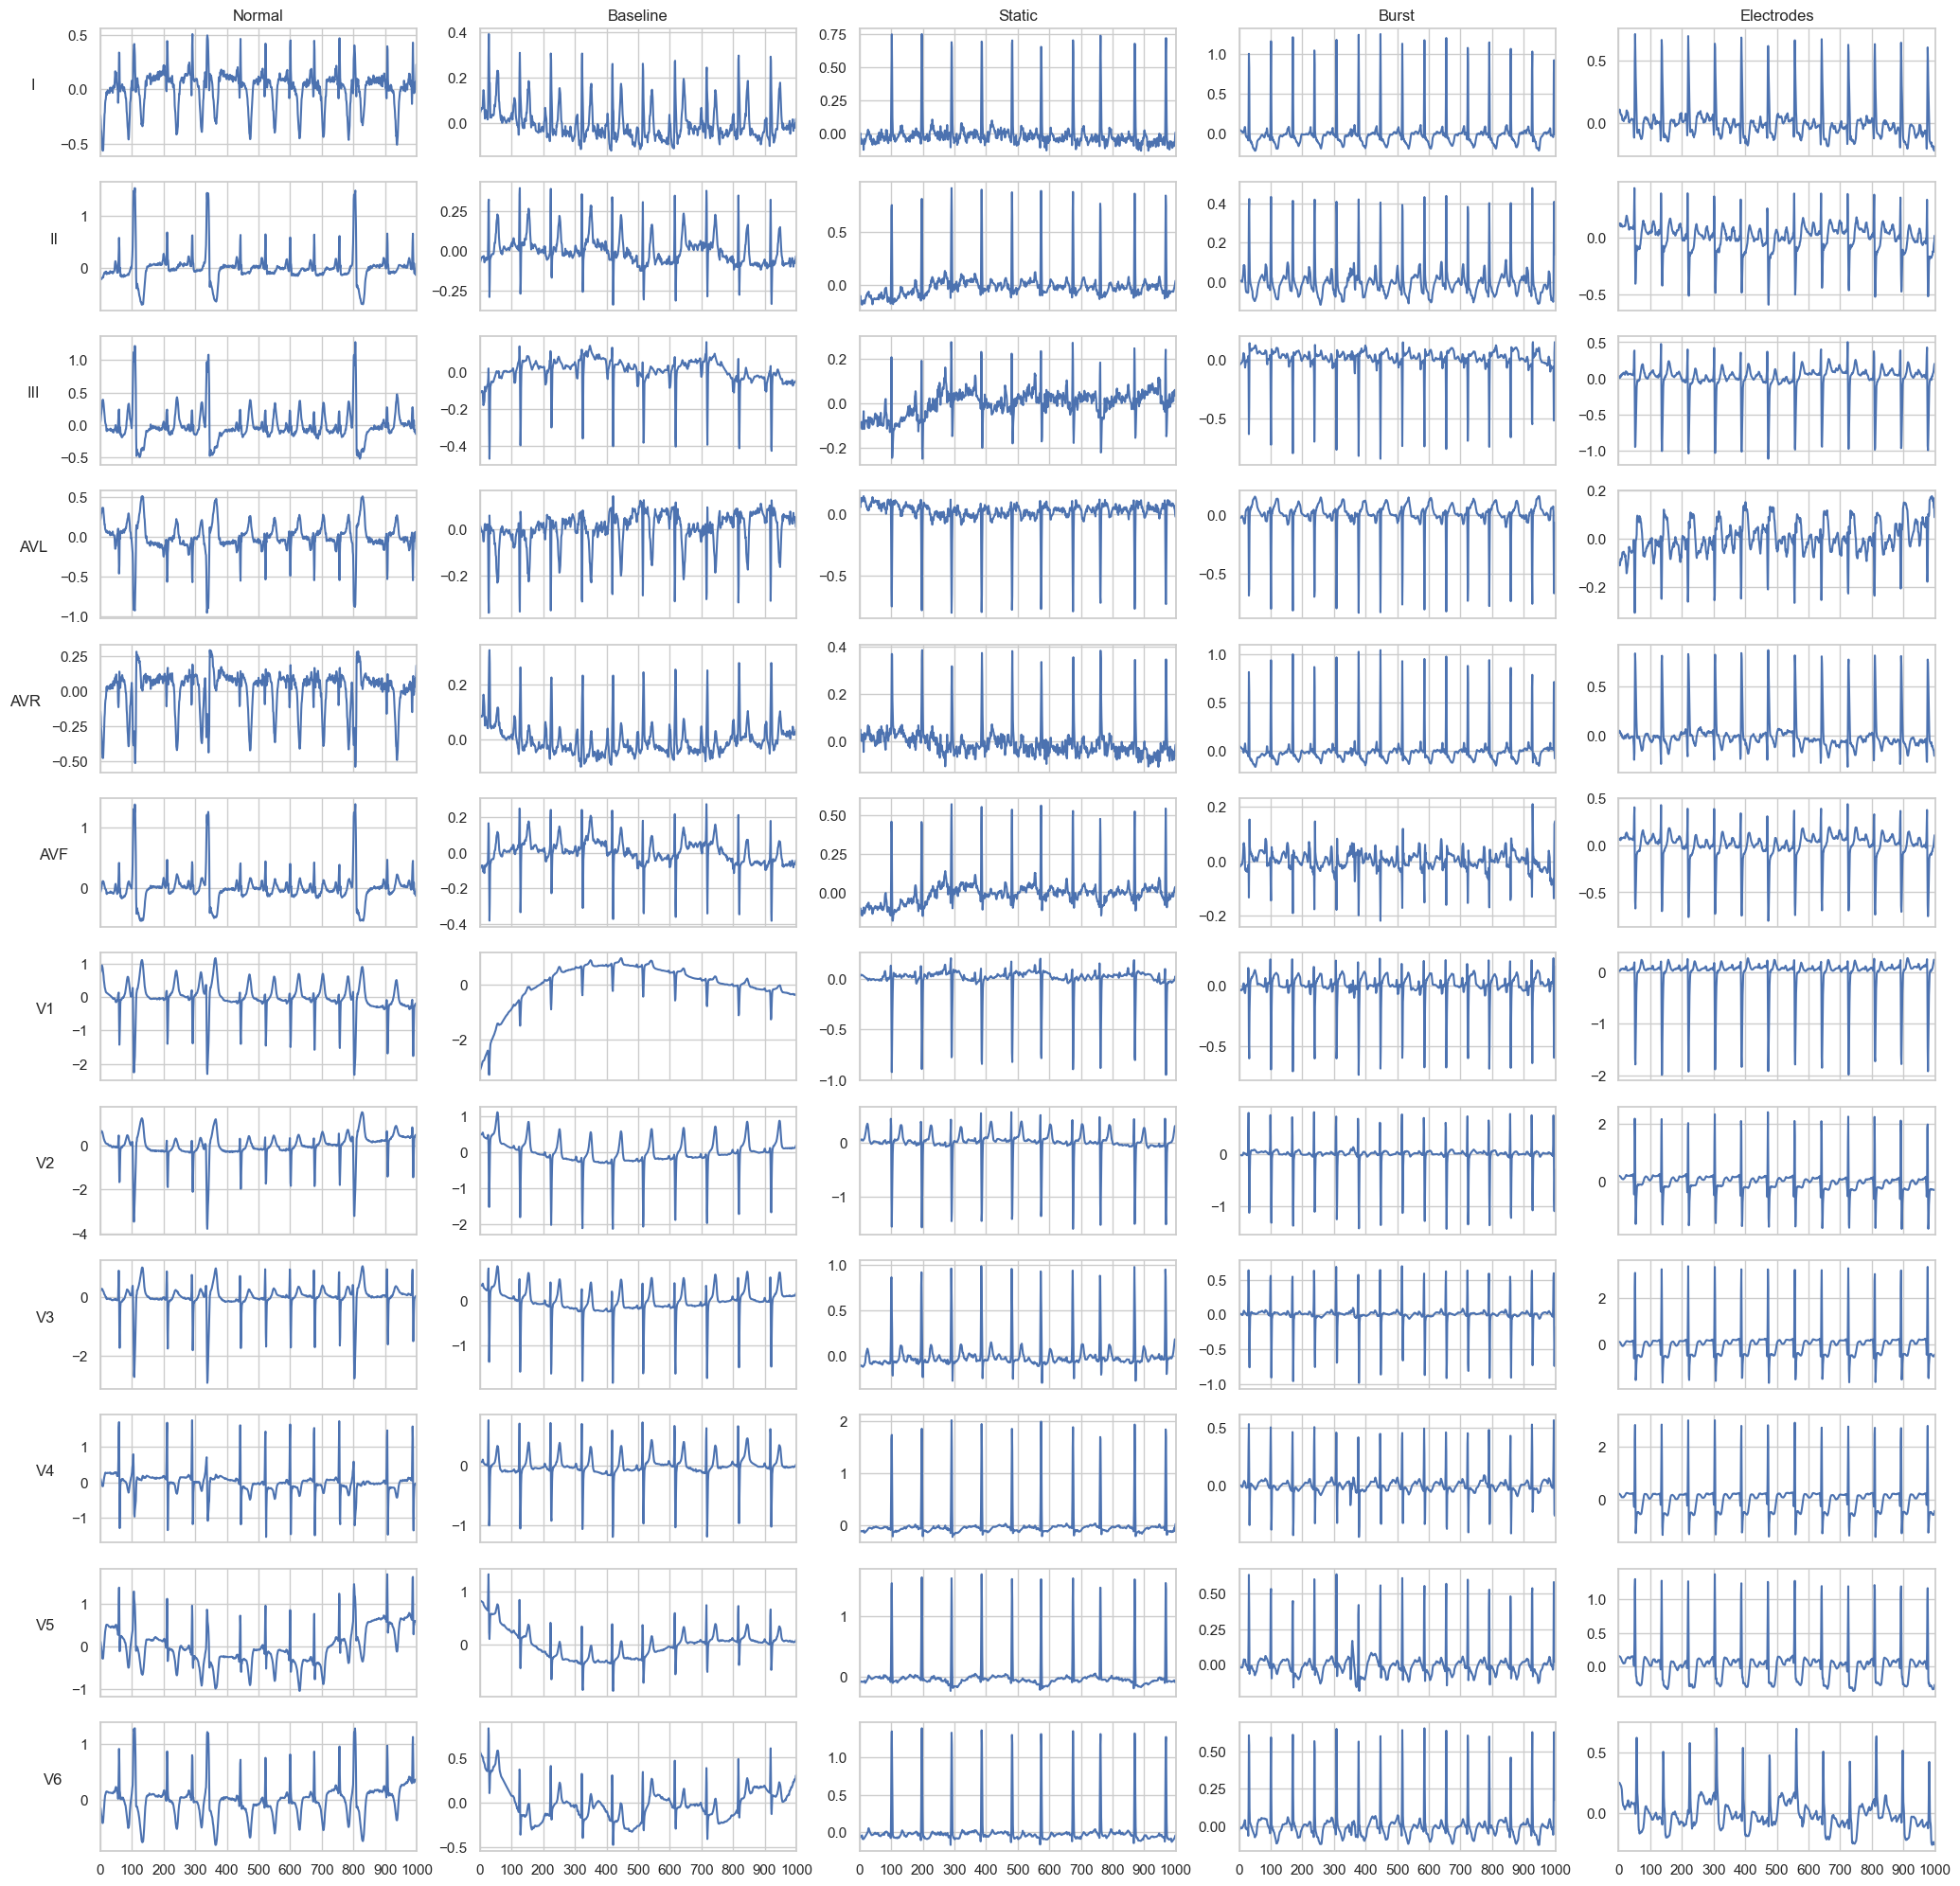

In [25]:
idx = 1
X_plot = [X_normal[idx], X_baseline[idx], X_static[idx], X_burst[idx], X_electrodes[idx]]

# Plot ECG
fig, axes = plt.subplots(nrows=12, ncols = 5, figsize=(25, 25), sharex=True)
leads = ['I', 'II', 'III', 'AVL', 'AVR', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
titles = ['Normal', 'Baseline', 'Static', 'Burst', 'Electrodes']

for j in range(5):
    ecg = X_plot[j]
    axes[0, j].set_title(titles[j])

    for i in range(12):
        axes[i,j].plot(ecg[:,i])
        axes[i,0].set_ylabel(leads[i], rotation=0, labelpad=20)
        
        axes[i,j].set_xlim([0, 1000])
        axes[i,j].set_xticks(np.arange(0, 1001, 100))

Ok, for me Baseline drifts and Electrode Problems show the most obvious issues.

The plan is to train a Denoising Autoencoder that will have as an input the noisy signal, and will return a filtered one (9). To train it, we will use only 'normal' signals, where some artificial noise will be added. For simplicity, we will use only lead I of the signals, although this approach could be easily extended to all the leads (and also make the autoencoder process them together, which would be much more powerful)

Let's start by testing some approaches of noise addition to the singal. Here I will focus on 2 sources of noise:
- Low freq. noise, to emulate a baseline drift
- High freq. noise, to emulate some interference (like static noise or electrode problems)

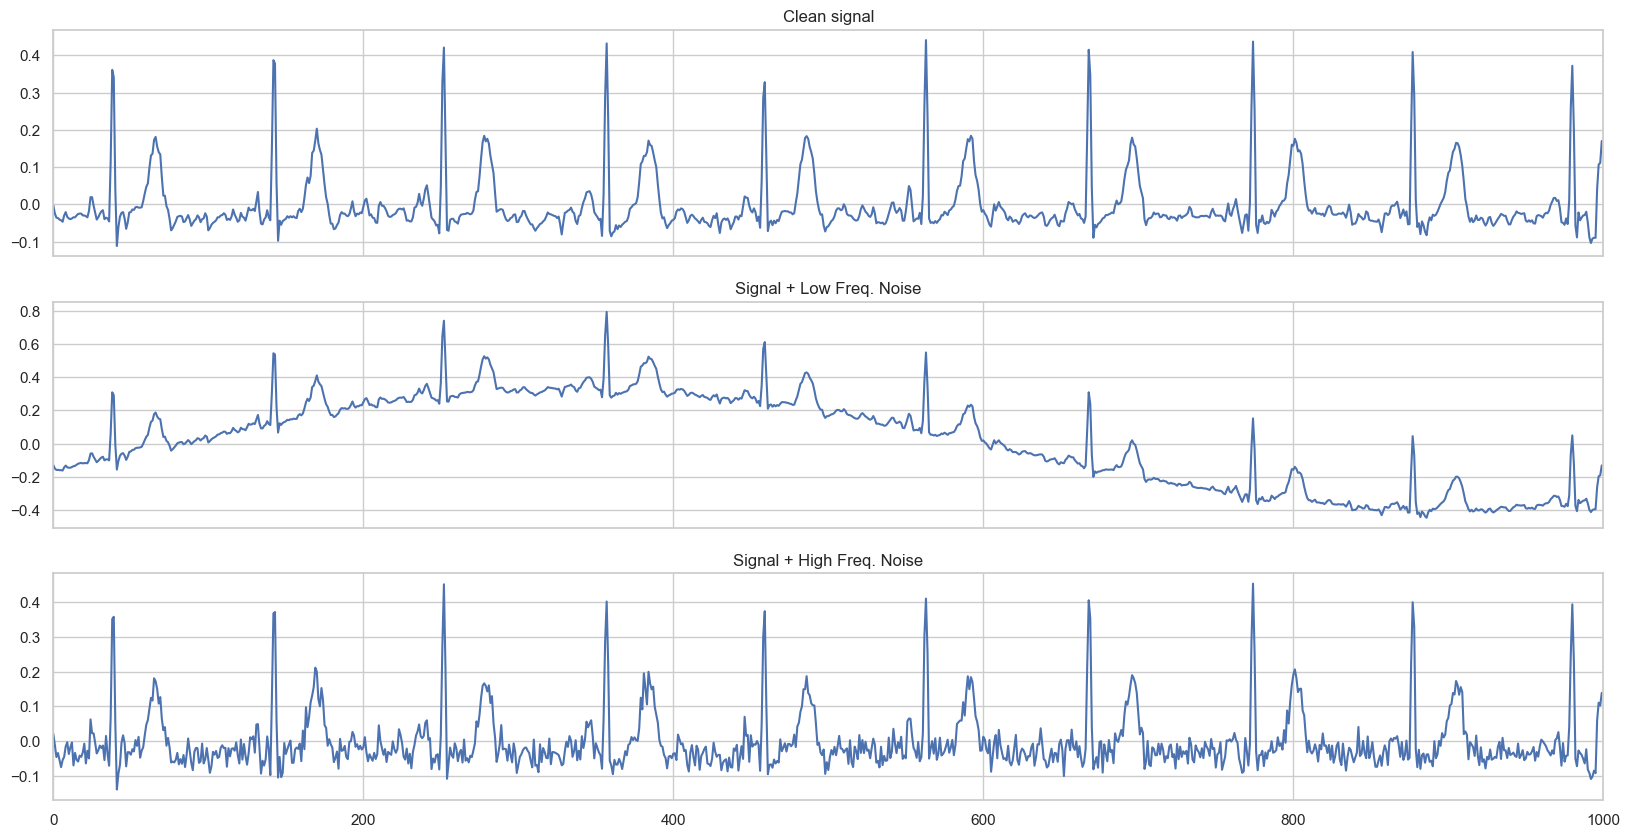

In [26]:
ecg = X_normal[0][:,0]
t = np.linspace(0, 1, 1000)

# Generate LF noise
lf_a = np.random.uniform(low=0, high=0.5)
lf_w = np.random.uniform(low=0.5, high=2.0)
lf_f = np.random.random()*2*np.pi
lf_noise = lf_a*np.cos(t*np.pi*lf_w + lf_f)


# Generate HF noise
hf_a = np.random.uniform(low=0, high=0.03)
hf_noise = np.random.normal(loc=0, scale=hf_a, size=1000)

# Plot results
fig, axes = plt.subplots(nrows=3, figsize=(20, 10), sharex=True)

axes[0].plot(ecg)
axes[0].set_title('Clean signal')
axes[0].set_xlim([0, 1000])

axes[1].plot(ecg + lf_noise)
axes[1].set_title('Signal + Low Freq. Noise')

axes[2].plot(ecg + hf_noise)
axes[2].set_title('Signal + High Freq. Noise')

plt.show()


Alright, now that we know how to add some noise to the ECG signals, let's put it into a custom data generator, that will continously create new samples by taking the ECG dataset, and adding random noise to them

In [27]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, data, batch_size,
                 input_size=(1000,),
                 shuffle=True):
        
        self.data = data
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = self.data.shape[0]
        self.indexes = np.arange(self.n)
        print('Dataset length = {0}'.format(self.n))

        self.sample_len = input_size[0]
        self.t = np.linspace(0, 1, self.sample_len)

        self.lf_a = [0, 0.5]
        self.lf_w = [0.5, 2.0]
        self.hf_a = [0, 0.03]

    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def lf_noise(self):
        noises = []
        for i in range(self.batch_size):
            a = np.random.uniform(low=self.lf_a[0], high=self.lf_a[1])
            w = np.random.uniform(low=self.lf_w[0], high=self.lf_w[1])
            f = np.random.random()*2*np.pi

            noise = a*np.cos(self.t*np.pi*w + f)
            noises.append(noise)

        return np.array(noises)

    def hf_noise(self):
        noises = []
        for i in range(self.batch_size):
            a = np.random.uniform(low=self.hf_a[0], high=self.hf_a[1])
            noise = np.random.normal(loc=0, scale=a, size=1000)
            noises.append(noise)

        return np.array(noises)
        
    
    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        x_ = self.data[indexes]
        scale = np.max(x_) - np.min(x_)
        y_ = x_ + scale*(self.lf_noise() + self.hf_noise())

        x = np.expand_dims(x_, axis=-1)
        y = np.expand_dims(y_, axis=-1)

        return y, x
    
    def __len__(self):
        return self.n // self.batch_size

Ok, let's plot some signals to verify that the generator is working as expected

Dataset length = 10


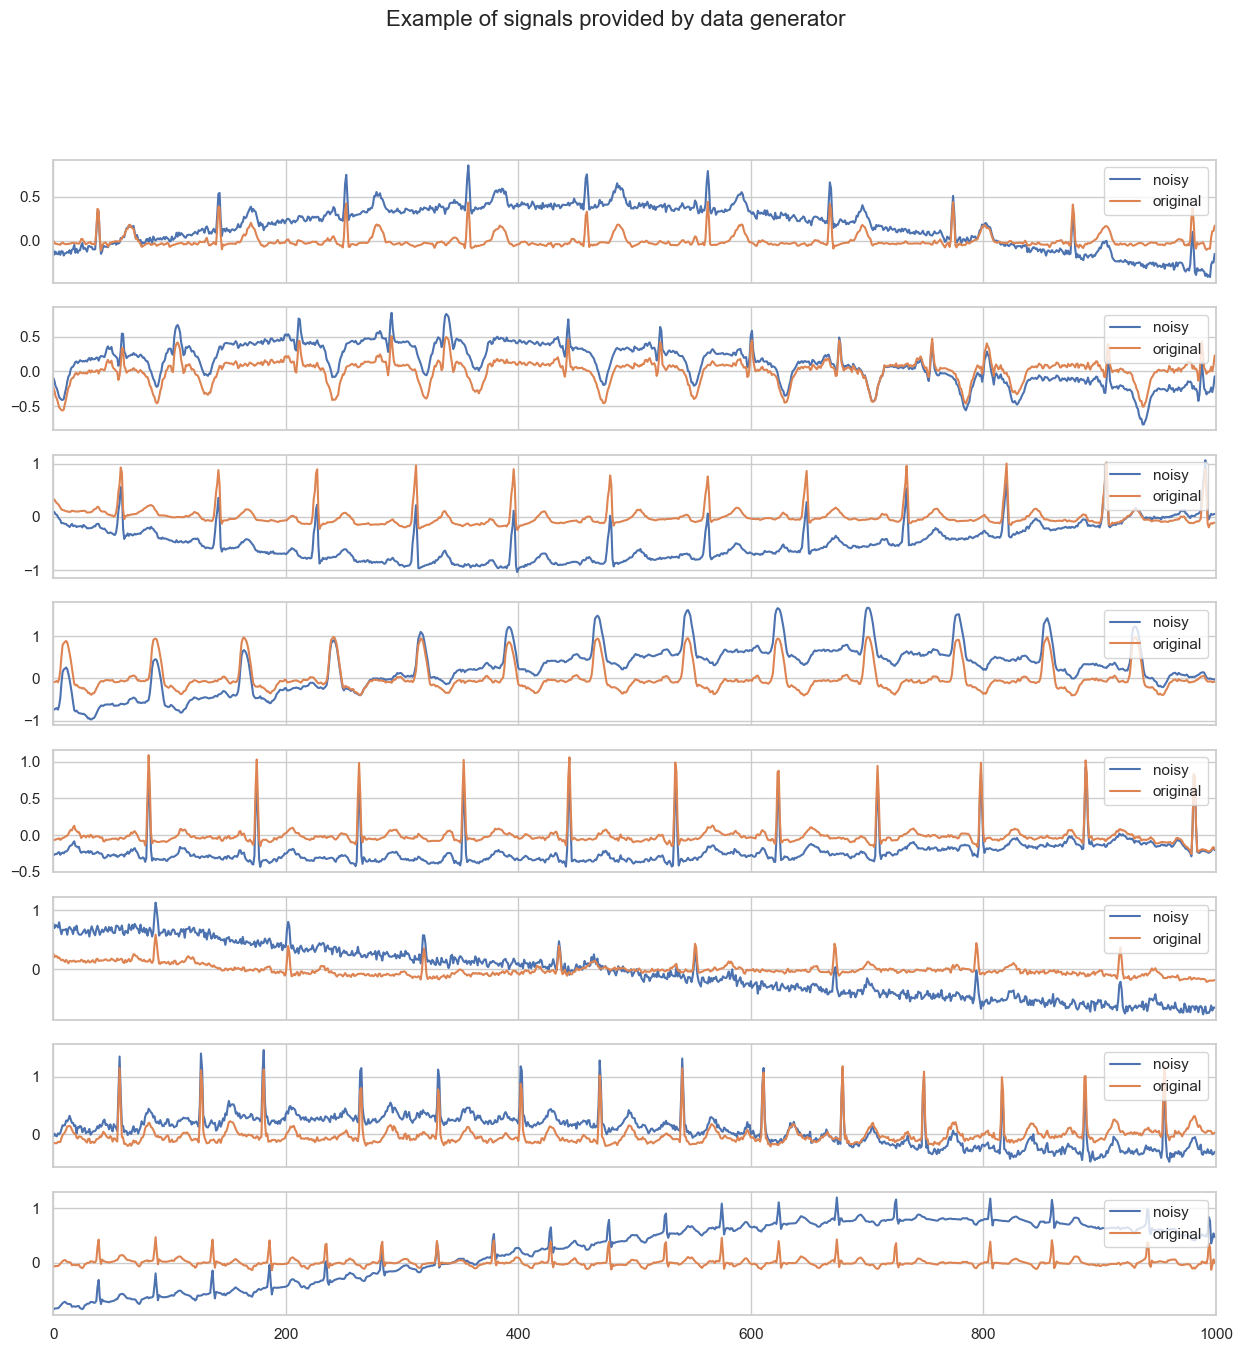

In [28]:
n_size = 8
data_gen = CustomDataGen(X_normal[:,:,0], n_size, input_size=(1000, 1))
x, y = data_gen[0]

fig, axes = plt.subplots(nrows=n_size, figsize=(15, 15), sharex=True)

for i in range(n_size):
    axes[i].plot(x[i], label='noisy')
    axes[i].plot(y[i], label='original')
    axes[i].set_xlim([0, 1000])
    axes[i].legend(loc='upper right')

fig.suptitle('Example of signals provided by data generator', fontsize=16)
plt.show()

Now, let's load the actual data that we will use to train and test the autoencoder. For this exercise, the proposed train-test will be used

In [29]:
Y_data = Y[Y.baseline_drift.isna() & 
              Y.static_noise.isna() & 
              Y.burst_noise.isna() & 
              Y.electrodes_problems.isna()]

X_data = load_raw_data(Y_data, sampling_rate, folder_name)

X_train_ = X[np.where(Y.strat_fold != test_fold)]
X_test_ = X[np.where(Y.strat_fold == test_fold)]

print('Train dataset shape: {0}'.format(X_train_.shape))
print('Test dataset shape: {0}'.format(X_test_.shape))

Train dataset shape: (19603, 1000, 12)
Test dataset shape: (2198, 1000, 12)


Create the train and test data generators

In [30]:
batch_size = 256

train_gen = CustomDataGen(X_train_[:,:,0], batch_size, input_size=(1000,), shuffle=False)
test_gen = CustomDataGen(X_test_[:,:,0], batch_size, input_size=(1000,), shuffle=False)

Dataset length = 19603
Dataset length = 2198


Alright, time to define the autoencoder. The autoencoder works creating some sort of information bottleneck in its core and decompressing back the signal. In order to achieve this, the important features must be kept, while other non-important data (such as noise) is discarded.

To avoid overfitting, L2 regularization is included, as well as batch normalization.

In [31]:
denoiser = models.Sequential()

kr = keras.regularizers.l2(1e-5)

# Encoder
denoiser.add(layers.Conv1D(32, 5, padding='same', input_shape=(1000,1), kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))
denoiser.add(layers.MaxPooling1D(2, padding='same'))
denoiser.add(layers.BatchNormalization())

denoiser.add(layers.Conv1D(64, 5, padding='same', kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))
denoiser.add(layers.MaxPooling1D(2, padding='same'))
denoiser.add(layers.BatchNormalization())

denoiser.add(layers.Conv1D(128, 5, padding='same', kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))
denoiser.add(layers.MaxPooling1D(2, padding='same'))
denoiser.add(layers.BatchNormalization())

# Decoder
denoiser.add(layers.Conv1D(64, 5, padding='same', kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))
denoiser.add(layers.UpSampling1D(2))
denoiser.add(layers.BatchNormalization())

denoiser.add(layers.Conv1D(32, 5, padding='same', kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))
denoiser.add(layers.UpSampling1D(2))
denoiser.add(layers.BatchNormalization())

denoiser.add(layers.Conv1D(8, 5, padding='same', kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))
denoiser.add(layers.UpSampling1D(2))
denoiser.add(layers.BatchNormalization())

denoiser.add(layers.Conv1D(1, 5, padding='same', kernel_regularizer=kr))
denoiser.add(layers.LeakyReLU(alpha=0.3))

denoiser.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 32)          192       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1000, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 32)          0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 500, 32)          128       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           10304     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 500, 64)          

Train!

In [32]:
denoiser.compile(optimizer='sgd',
              loss='mse',
              )

history = denoiser.fit(train_gen, epochs=400, validation_data=test_gen)

Epoch 1/400
76/76 [==============================] - 20s 246ms/step - loss: 0.0633 - val_loss: 0.0311
Epoch 2/400
76/76 [==============================] - 18s 239ms/step - loss: 0.0275 - val_loss: 0.0310
Epoch 3/400
76/76 [==============================] - 18s 240ms/step - loss: 0.0237 - val_loss: 0.0313
Epoch 4/400
76/76 [==============================] - 18s 241ms/step - loss: 0.0216 - val_loss: 0.0296
Epoch 5/400
76/76 [==============================] - 18s 240ms/step - loss: 0.0203 - val_loss: 0.0248
Epoch 6/400
76/76 [==============================] - 18s 233ms/step - loss: 0.0194 - val_loss: 0.0209
Epoch 7/400
76/76 [==============================] - 18s 240ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 8/400
76/76 [==============================] - 18s 239ms/step - loss: 0.0181 - val_loss: 0.0170
Epoch 9/400
76/76 [==============================] - 18s 240ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 10/400
76/76 [==============================] - 18s 239ms/step - loss: 0.017

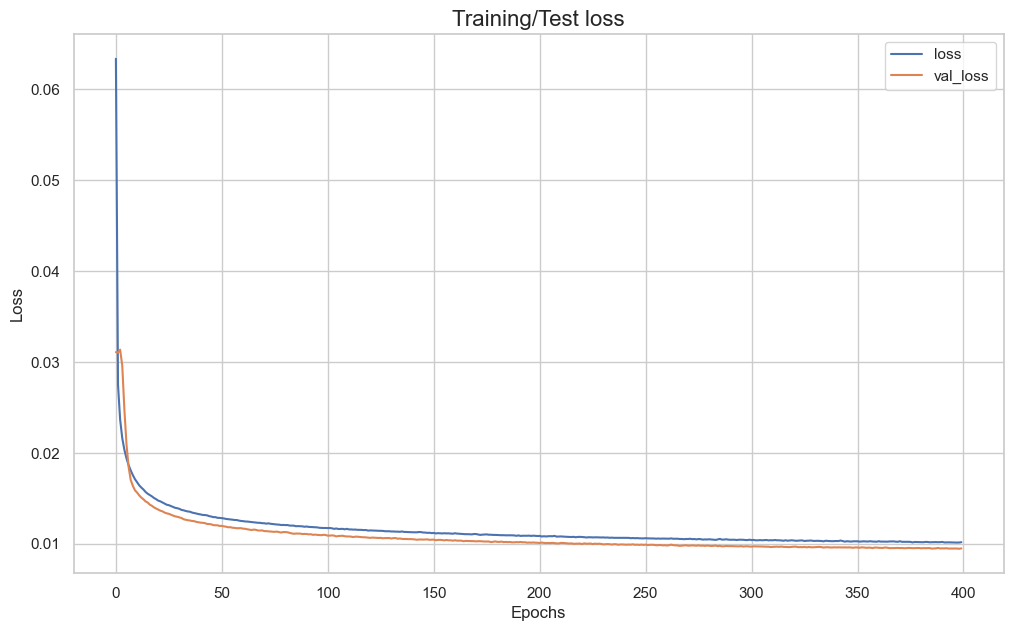

In [33]:
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training/Test loss', fontsize=16)
plt.legend()
plt.show()

Ok, so let's check what is the result of our Denoiser

8/8 [==============================] - 0s 11ms/step


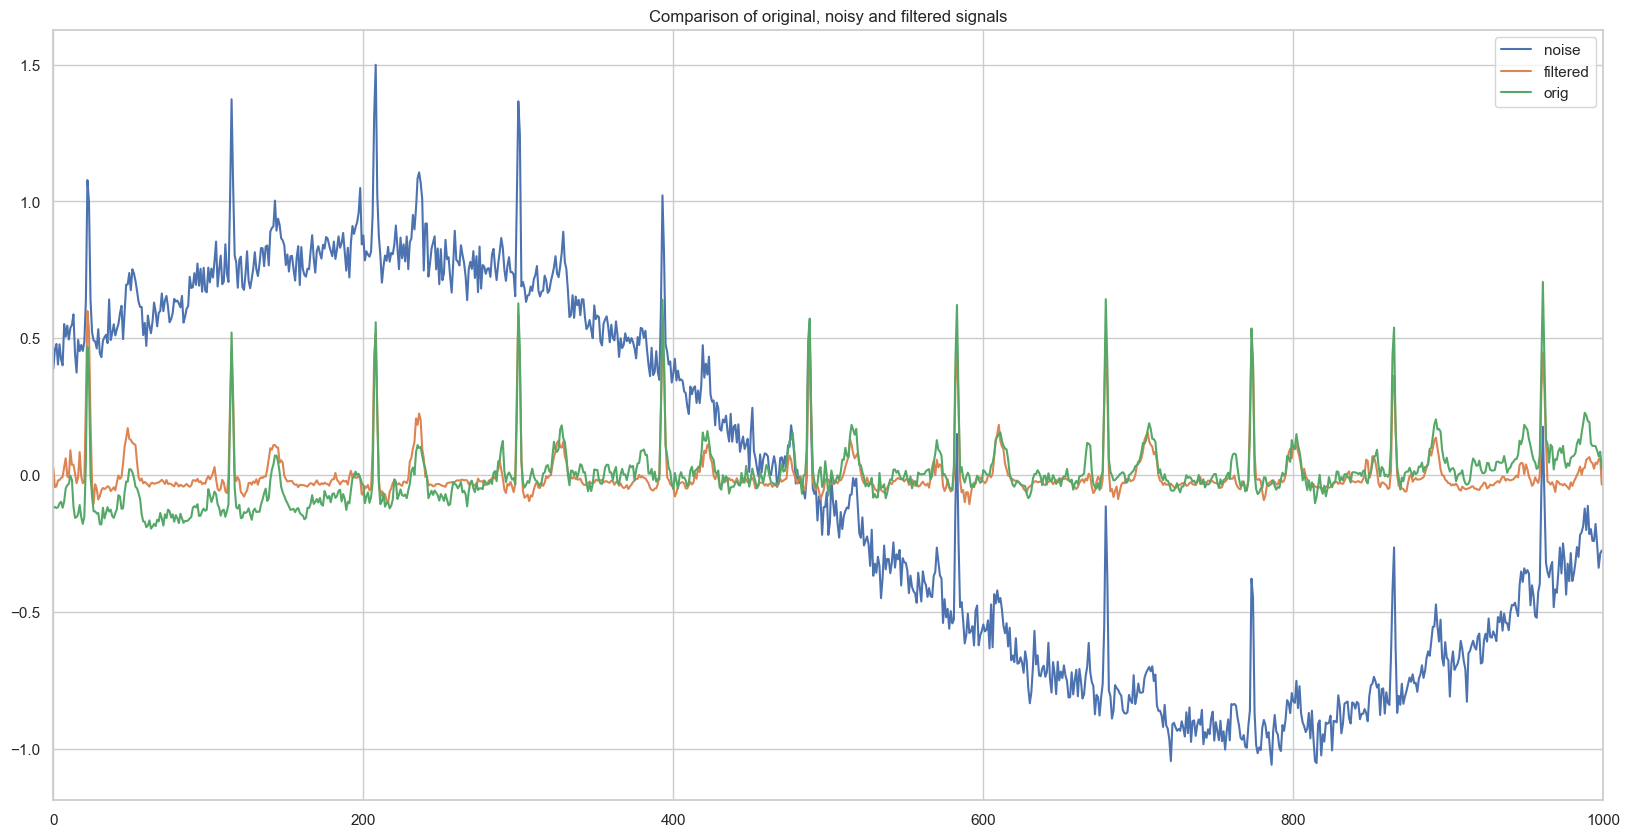

In [34]:
# Load a batch and run the network on it
x, y = train_gen[0]
y_pred = denoiser.predict(x)

# Plot signals
plt.figure(figsize=(20,10))
plt.plot(x[0,:,0], label='noise')
plt.plot(y_pred[0,:,0], label='filtered')
plt.plot(y[0,:,0], label='orig')
plt.legend()
plt.xlim([0, 1000])
plt.title('Comparison of original, noisy and filtered signals')

plt.show()

Nice, it seems that the denoiser is able even to remove some baseline drift present in the original signal. Aparently the signal useful information is still there, although some of the peaks present in the origianl ECG are also filtered (around sample #900). 

Now let's see what happens if we apply the denoiser to a signal with true noise from the dataset.

1/1 [==============================] - 0s 180ms/step


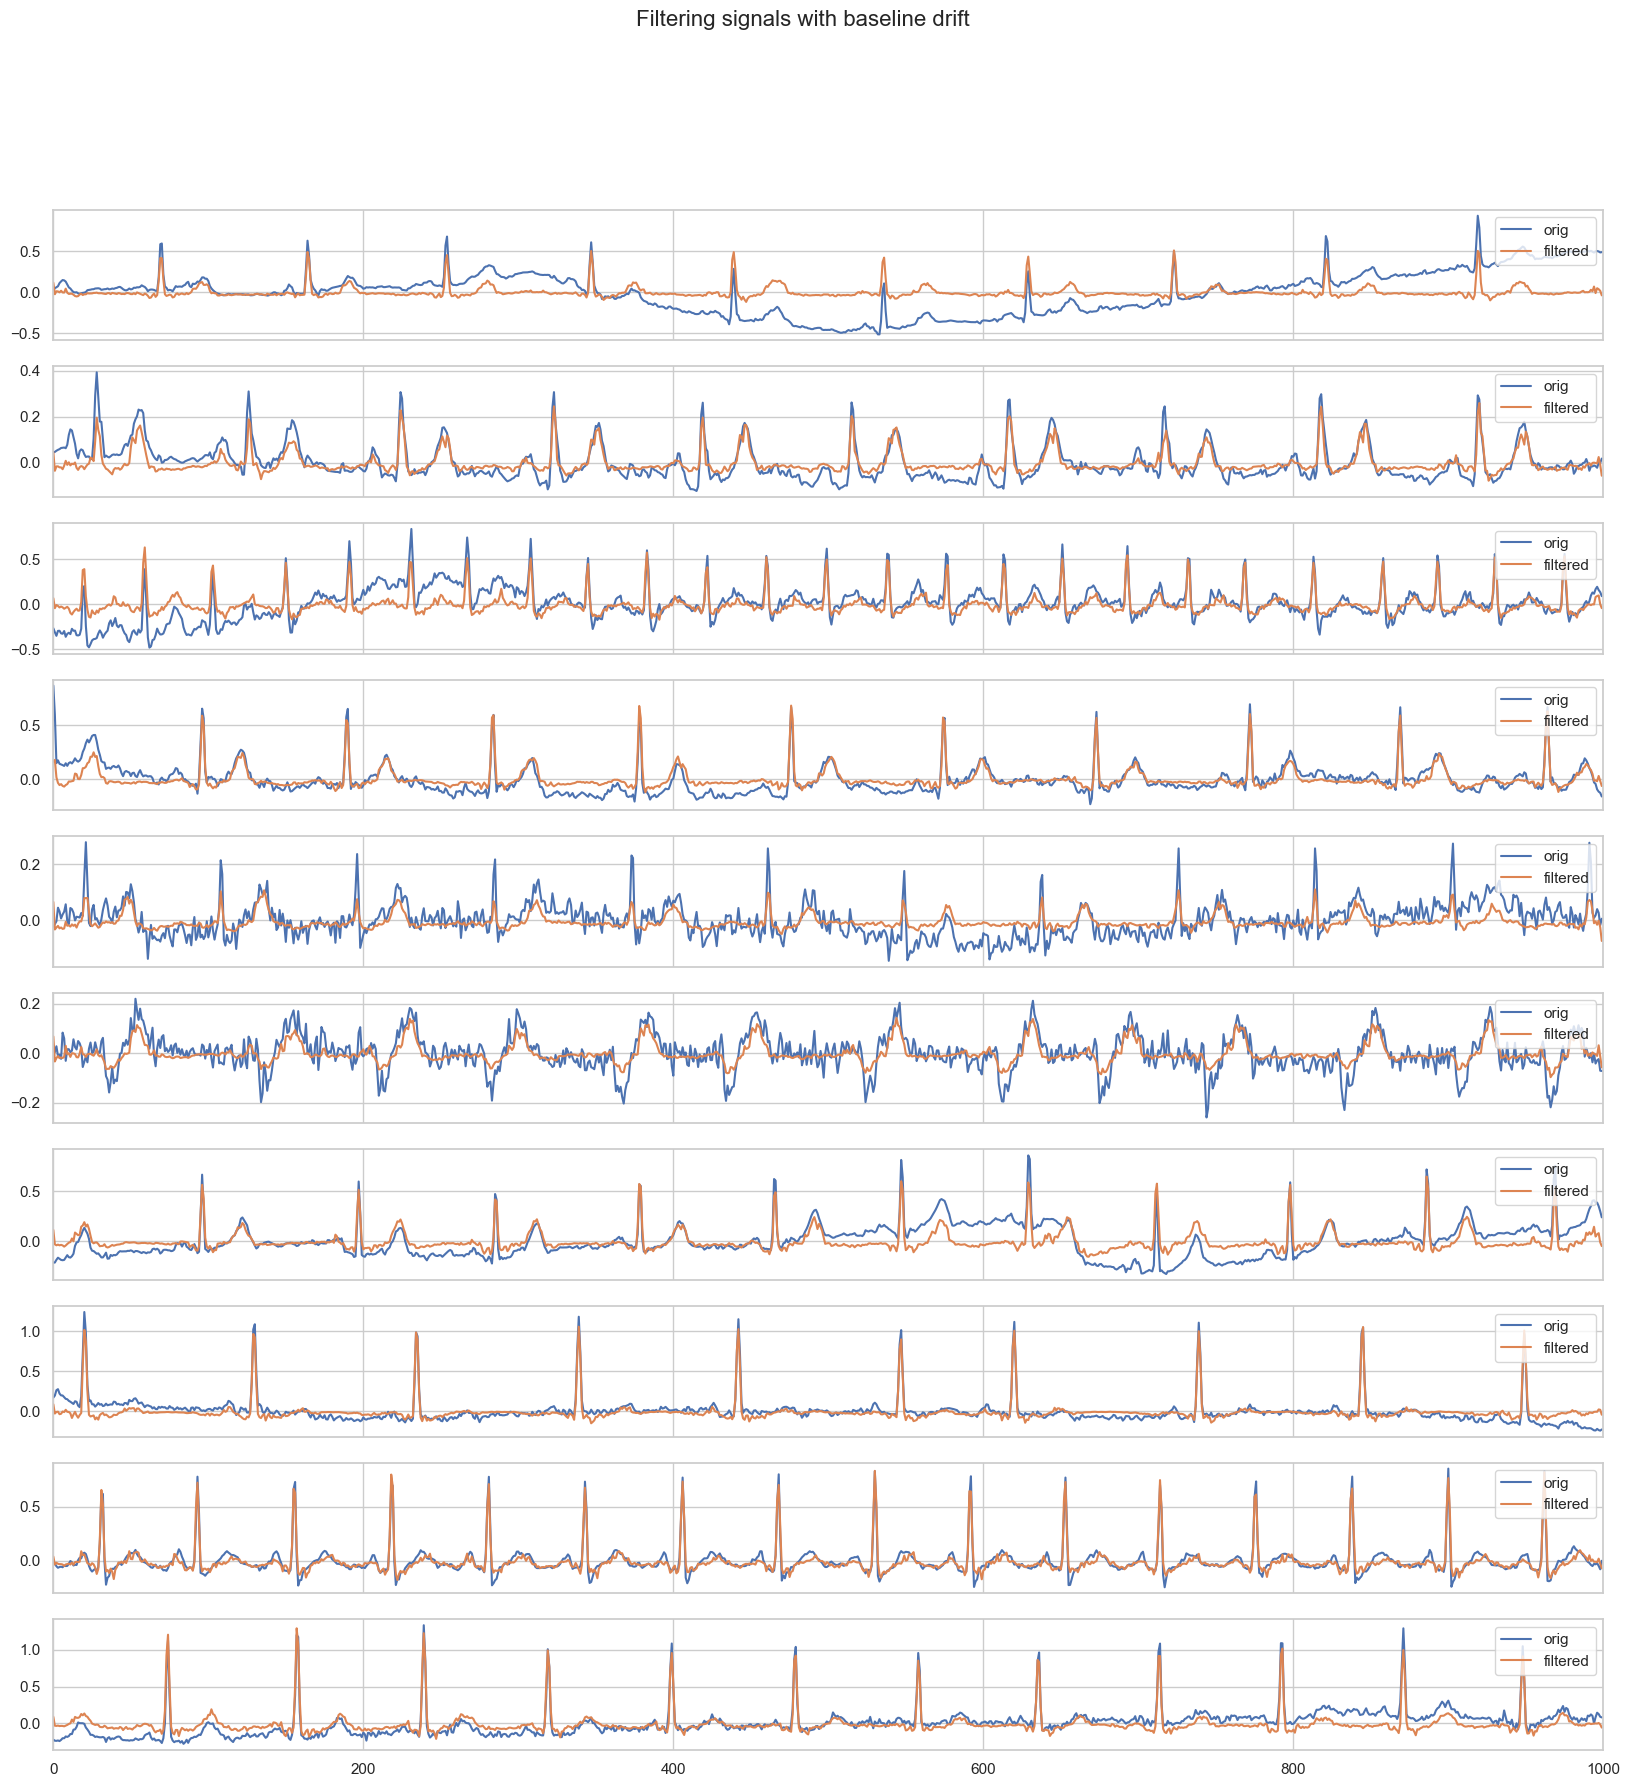

In [35]:
# Process data
x = np.expand_dims(X_baseline[:,:,0], axis=-1)
yp = denoiser.predict(x)

# Plot signals
fig, axes = plt.subplots(nrows=10, figsize=(20, 20), sharex=True)
fig.suptitle('Filtering signals with baseline drift', fontsize=16)
for i in range(10):
    axes[i].plot(x[i,:,0], label='orig')
    axes[i].plot(yp[i,:,0], label='filtered')
    axes[i].legend(loc='upper right')
    axes[i].set_xlim([0, 1000])

plt.show()


1/1 [==============================] - 0s 16ms/step


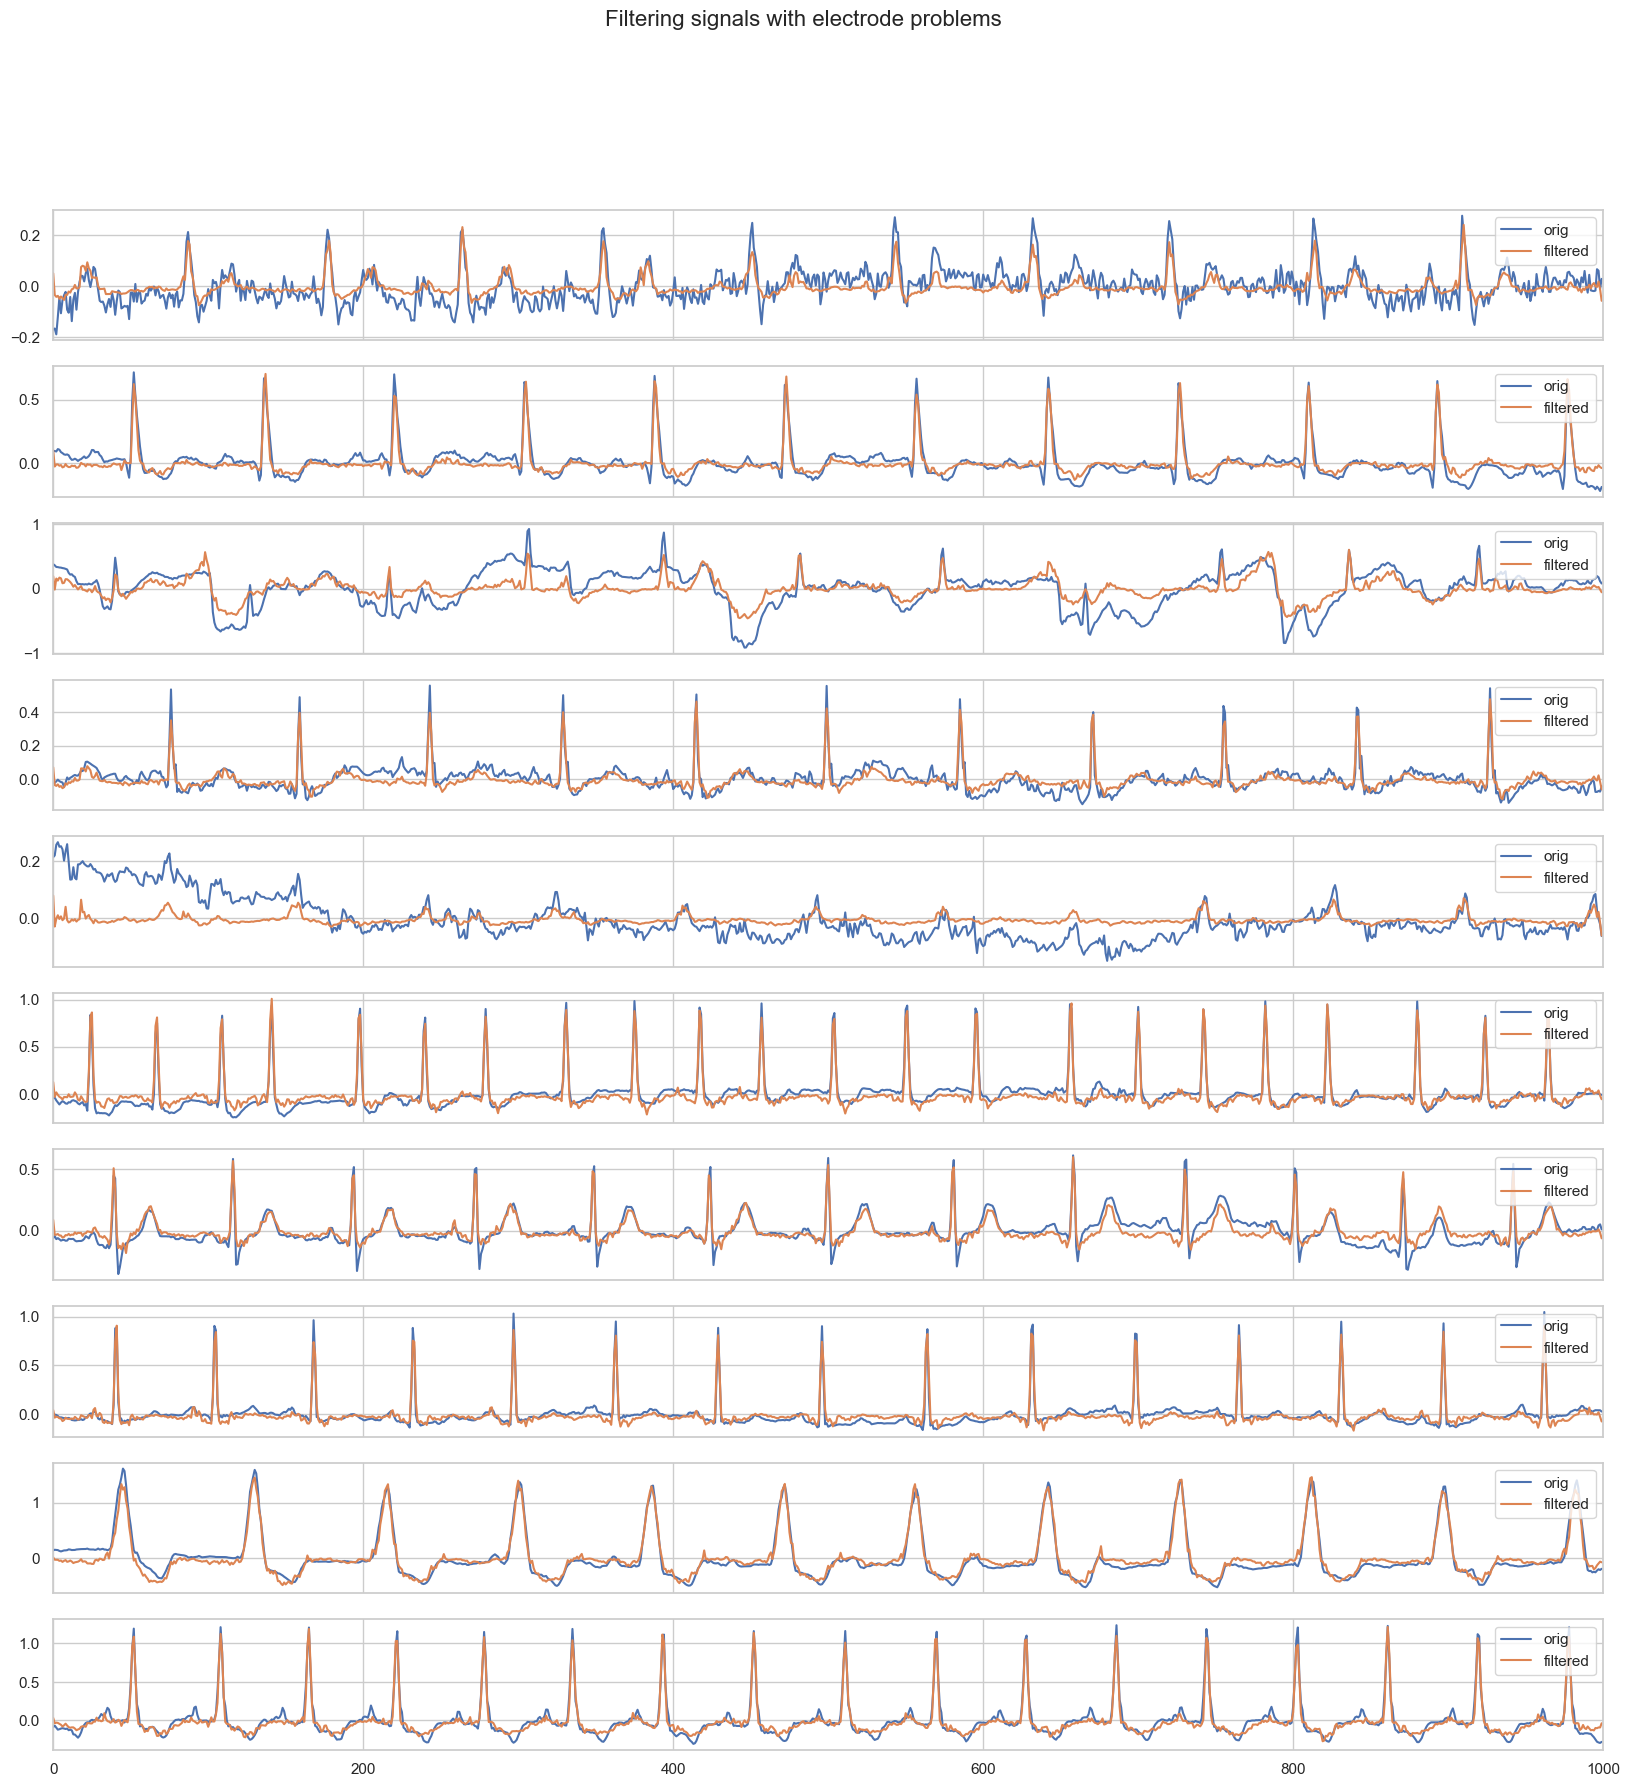

In [36]:
# Process data
x = np.expand_dims(X_electrodes[:,:,0], axis=-1)
yp = denoiser.predict(x)

# Plot signals
fig, axes = plt.subplots(nrows=10, figsize=(20, 20), sharex=True)
fig.suptitle('Filtering signals with electrode problems', fontsize=16)
for i in range(10):
    axes[i].plot(x[i,:,0], label='orig')
    axes[i].plot(yp[i,:,0], label='filtered')
    axes[i].legend(loc='upper right')
    axes[i].set_xlim([0, 1000])

plt.show()


So, it seems that the network is able to do a really nice work filtering problems in the signals. For sure an algorithm like this would need a lot of work to validate that no artifacts are introduced by the denoising autoencoder, but this technique shows very promising results.

# References <a class="anchor" id="references" ></a> [(Go Up)](#intro)


1. Dataset - https://physionet.org/content/ptb-xl/1.0.2/

2. N. Strodthoff, P. Wagner, T. Schaeffter and W. Samek, "Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL," in IEEE Journal of Biomedical and Health Informatics, vol. 25, no. 5, pp. 1519-1528, May 2021, doi: 10.1109/JBHI.2020.3022989.
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9190034

3. HeartPy - Python Heart Rate Analysis Toolkit - https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/index.html

4. Khan, N. and Niaz Imtiaz, M., “Pan-Tompkins++: A Robust Approach to Detect R-peaks in ECG Signals”, <i>arXiv e-prints</i>, 2022. doi:10.48550/arXiv.2211.03171.

5. Maghfiroh, A.M. et al. (2021). State-of-the-Art Method to Detect R-Peak on Electrocardiogram Signal: A Review. In: Triwiyanto, Nugroho, H.A., Rizal, A., Caesarendra, W. (eds) Proceedings of the 1st International Conference on Electronics, Biomedical Engineering, and Health Informatics. Lecture Notes in Electrical Engineering, vol 746. Springer, Singapore. https://doi.org/10.1007/978-981-33-6926-9_27

6. Sadhukhan, D., & Mitra, M. (2012). R-peak detection algorithm for ECG using double difference and RR interval processing. Procedia Technology, 4, 873-877, https://doi.org/10.1016/j.protcy.2012.05.143

7. Chatterjee, S., Thakur, R.S., Yadav, R.N., Gupta, L. and Raghuvanshi, D.K. (2020), Review of noise removal techniques in ECG signals. IET Signal Process., 14: 569-590. https://doi.org/10.1049/iet-spr.2020.0104

8. Rahul Kher (2019) Signal Processing Techniques for Removing Noise from ECG Signals. J Biomed Eng 1: 1-9.

9. H. -T. Chiang, Y. -Y. Hsieh, S. -W. Fu, K. -H. Hung, Y. Tsao and S. -Y. Chien, "Noise Reduction in ECG Signals Using Fully Convolutional Denoising Autoencoders," in IEEE Access, vol. 7, pp. 60806-60813, 2019, doi: 10.1109/ACCESS.2019.2912036.

